## Linear Regression Project

### Scenario: 
We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. **We need to estimate the price of a XoX before we recommend it to our customers.** However, the estimations vary significantly with our employees' experience. 

We would like to build a machine learning model to accurately predict the price for a future purchase and provide insights to help explain the predicted price to our customers. A sample of our sales record is available in ../data/sales.csv.

1. Preprocess, clean, analyze and visualized the provided data.
2. Build a machine learning model to help determine the price for a purchase.
3. Help understand how the price is predicted

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import statistics as stats

%matplotlib inline

pd.set_option('display.max_rows', 1000) 

df0 = pd.read_csv('../data/sales.csv')
# df0 = pd.read_csv('sales.csv')
df0.dropna(subset=['price'], inplace=True)
df0 = df0.reset_index(drop=True)

# 1. Pre-model Analysis:

## 1.1 Pre-model Analysis: data characteristic

In [4]:
df0.tail(10)

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
3176,NaN,"$25,442",2 Ton 980 Kg,Nov 07 1997,J,intermediate,NaN,NaN,2.39 meters,103 cm,27 cm
3177,$207k,"$106,642",3 Ton 560 Kg,Dec 14 2007,U,super advanced,M14545,"IN732929,IN732691,IN732658,IN732087,IN732419,I...",2.49 meters,110 cm,29 cm
3178,$77k,"$240,192",2 Ton 810 Kg,Jul 16 2010,"N,D",super advanced,M14148,"IN732112,IN732184,IN732500,IN732674,IN732198,I...",2.28 meters,102 cm,27 cm
3179,$254k,"$255,179",3 Ton 40 Kg,Apr 20 2012,D,intermediate,M14261,"IN732220,IN732456,IN733681,IN732831,IN733123,I...",2.02 meters,113 cm,30 cm
3180,$91k,"$144,631",2 Ton 890 Kg,Jul 12 2002,D,advanced,M14904,"IN732503,IN732583,IN732373,IN732338,IN732347,I...",2.52 meters,99 cm,26 cm
3181,NaN,"$93,349",3 Ton 0 Kg,Nov 25 2016,D,advanced,M14904,"IN732490,IN732338,IN732503,IN732435,IN732583",2.02 meters,112 cm,29 cm
3182,NaN,"$40,384",2 Ton 830 Kg,May 25 2007,"J,B",intermediate,M14578,"IN732832,IN732166,IN733162,IN733785,IN732069,I...",2.15 meters,106 cm,28 cm
3183,NaN,"$1,074,844",3 Ton 80 Kg,Dec 16 2016,C,intermediate,"M14883,M15011","IN733462,IN732654,IN732149,IN733067,IN734088,I...",2.84 meters,96 cm,25 cm
3184,$44k,"$55,931",2 Ton 950 Kg,Apr 12 2002,R,advanced,M14341,IN732587,2.52 meters,100 cm,26 cm
3185,$128k,"$44,370",2 Ton 980 Kg,Jun 13 2003,N,super advanced,NaN,NaN,2.96 meters,92 cm,24 cm


In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 11 columns):
cost             2211 non-null object
price            3186 non-null object
weight           3183 non-null object
purchase_date    3186 non-null object
product_type     3186 non-null object
product_level    3186 non-null object
maker            2365 non-null object
ingredient       2932 non-null object
height           3186 non-null object
width            3183 non-null object
depth            3183 non-null object
dtypes: object(11)
memory usage: 273.9+ KB


In [6]:
df0.describe(include='all')    # exclusive of 'NaN' value

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2211,3186,3183,3186,3186,3186,2365,2932,3186,3183,3183
unique,185,3157,119,1277,64,5,879,2824,161,41,13
top,$66k,"$92,392",3 Ton 0 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,126,8,485,1320,17,8,63,268,899


In [7]:
len(df0.cost.unique())  # inclusive of "NaN"

186

In [8]:
df0.columns

Index(['cost', 'price', 'weight', 'purchase_date', 'product_type',
       'product_level', 'maker', 'ingredient', 'height', 'width', 'depth'],
      dtype='object')

In [9]:
df0['year'] = pd.to_datetime(df0.purchase_date).dt.year
train_raw = df0[df0.year < 2015].reset_index(drop=True)
test_raw = df0[df0.year >= 2015].reset_index(drop=True)
len(train_raw), len(test_raw)

(2757, 429)

## 1.2 Pre-model Analysis: numeric data transformation and cleaning

In [10]:
def char2num(X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X.purchase_date).dt.year
        df['purchase_date'] = pd.to_datetime(X.purchase_date)
        df['price'] = X.price.map(lambda x:float(x.strip('$').replace(',', '')) if type(x) == str else x)         
        df['cost'] = X.cost.map(lambda x: float(x.strip('$').rstrip('k').replace(',', '') ) * 1000 if type(x) == str else x)
        df['weight'] = X.weight.map(lambda x: 1000.*float(x.split()[0]) + float(x.split()[2]) if type(x) == str else x)
        df['height'] = X.height.map(lambda x: 100.*float(x.split()[0]) if type(x) == str else x)
        df['width'] = X.width.map(lambda x: float(x.split()[0]) if type(x) == str else x)
        df['depth'] = X.depth.map(lambda x: float(x.split()[0]) if type(x) == str else x)
        df['volumn'] = 100 * df['height'] * df['width'] * df['depth']
        return df.fillna(df.mean())
df = char2num(df0)
df

,year,purchase_date,price,cost,weight,height,width,depth,volumn
0,2008,2008-12-19,300492.0,333000.000000,3090.0,276.0,97.0,26.0,69607200.0
1,1997,1997-09-10,430570.0,169019.448213,3030.0,267.0,98.0,26.0,68031600.0
2,2001,2001-09-05,213070.0,270000.000000,3040.0,300.0,93.0,24.0,66960000.0
3,2016,2016-12-23,229174.0,169019.448213,3050.0,250.0,102.0,27.0,68850000.0
4,2000,2000-01-12,122659.0,97000.000000,2970.0,247.0,101.0,26.0,64862200.0
...,...,...,...,...,...,...,...,...,...
3181,2016,2016-11-25,93349.0,169019.448213,3000.0,202.0,112.0,29.0,65609600.0
3182,2007,2007-05-25,40384.0,169019.448213,2830.0,215.0,106.0,28.0,63812000.0
3183,2016,2016-12-16,1074844.0,169019.448213,3080.0,284.0,96.0,25.0,68160000.0
3184,2002,2002-04-12,55931.0,44000.000000,2950.0,252.0,100.0,26.0,65520000.0


In [11]:
df = pd.concat([df, df0[['product_type', 'product_level', 'maker', 'ingredient']] ], axis=1)
df.head()

,year,purchase_date,price,cost,weight,height,width,depth,volumn,product_type,product_level,maker,ingredient
0,2008,2008-12-19,300492.0,333000.000000,3090.0,276.0,97.0,26.0,69607200.0,"Q,B",advanced,M14122,"IN732052,IN732053"
1,1997,1997-09-10,430570.0,169019.448213,3030.0,267.0,98.0,26.0,68031600.0,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058"
2,2001,2001-09-05,213070.0,270000.000000,3040.0,300.0,93.0,24.0,66960000.0,"J,D",basic,NaN,"IN732054,IN732059,IN732060"
3,2016,2016-12-23,229174.0,169019.448213,3050.0,250.0,102.0,27.0,68850000.0,U,advanced,M14123,"IN732061,IN732062,IN732063"
4,2000,2000-01-12,122659.0,97000.000000,2970.0,247.0,101.0,26.0,64862200.0,"D,R",advanced,NaN,"IN732064,IN732065,IN732066"


## 1.3 Pre-model Analysis: descriptive statistics about numerical variables and categoricals

In [12]:
from scipy.stats import describe
describe(df[['cost','price']], axis=0)

DescribeResult(nobs=3186, minmax=(array([3000., 3131.]), array([ 945000., 2945329.])), mean=array([169019.44821348, 182317.63684871]), variance=array([1.46752082e+10, 4.86254343e+10]), skewness=array([1.97318862, 3.45714334]), kurtosis=array([ 5.55926358, 20.30652088]))

In [13]:
stats = df.describe()
stats.loc['var'] = df.var().tolist()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
#print(stats)
#print(stats.transpose())
stats.transpose()

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
year,3186.0,2.006872e+03,6.008380e+00,1996.0,2002.00,2.007000e+03,2012.0,2017.0,3.610063e+01,-0.026165,-1.137464
price,3186.0,1.823176e+05,2.205118e+05,3131.0,51540.75,1.105225e+05,222622.0,2945329.0,4.862543e+10,3.458772,20.340311
cost,3186.0,1.690194e+05,1.211413e+05,3000.0,88000.00,1.690194e+05,176000.0,945000.0,1.467521e+10,1.974118,5.569884
weight,3186.0,3.072208e+03,1.790193e+02,2630.0,2950.00,3.040000e+03,3170.0,4120.0,3.204791e+04,1.205604,2.630741
height,3186.0,2.628586e+02,2.704489e+01,170.0,245.00,2.620000e+02,281.0,350.0,7.314262e+02,0.019300,0.004673
width,3186.0,9.988847e+01,5.533270e+00,83.0,96.00,9.900000e+01,103.0,129.0,3.061708e+01,0.521395,0.893369
depth,3186.0,2.618190e+01,1.478860e+00,22.0,25.00,2.600000e+01,27.0,34.0,2.187026e+00,0.520320,0.928859
volumn,3186.0,6.828061e+07,4.047812e+06,58560000.0,65379600.00,6.767040e+07,70498275.0,91977200.0,1.638478e+13,1.164256,2.523096


In [14]:
df.describe(include=[np.object])  #.unstack()              #[np.number]  #exclude = np.object

,product_type,product_level,maker,ingredient
count,3186,3186,2365,2932
unique,64,5,879,2824
top,D,advanced,M14196,IN732638
freq,485,1320,17,8


In [15]:
df.isnull().sum()

year               0
purchase_date      0
price              0
cost               0
weight             0
height             0
width              0
depth              0
volumn             0
product_type       0
product_level      0
maker            821
ingredient       254
dtype: int64

### finding outliers for numeric variables

In [16]:
def findOutliers(x):
    Q1 = df[x].quantile(0.25, interpolation='linear')
    Q3 = df[x].quantile(0.75, interpolation='linear')
    IQR = Q3 - Q1
    Lowerfence = Q1 - 1.5*IQR
    Upperfence = Q3 + 1.5*IQR
    OUTLIERS = df.loc[(df[x] < Lowerfence)  |  (df[x] > Upperfence) ][x]
    #OUTLIERS = pd.merge(df[['year']], OUTLIERS, left_index=True, right_index=True, right_on=right_index)
    OUTLIERS = pd.concat([df[['year']], OUTLIERS],  axis=1)
    OUTLIERS.dropna(subset=[x], inplace=True)
    return len(OUTLIERS)
# checkOutliers = findOutliers("cost")
# checkOutliers

li = list(df.describe().columns)#.remove('year')
dic_out = {}
for item in li:
    dic_out[item] = findOutliers(item)
dic_out

{'year': 0,
 'price': 246,
 'cost': 324,
 'weight': 79,
 'height': 23,
 'width': 48,
 'depth': 25,
 'volumn': 77}

In [17]:
# fig, axes = plt.subplots(3,1, figsize=(14, 14))
# sns.set_context("paper", font_scale=1.2, rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":18})
# axes ={1: "pearson", 2: "spearman", 3: "kendall"}
# for ax in axes:
#     ax = sns.heatmap(df.corr(axes[ax]), annot=True, fmt=".2f")
#     #plt.title("Pearson correlation heatmap")
#     plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")  
#     #ax.set_yticklabels(rotation=0)
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  
#     #ax.set_xticks(rotation=30)
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)


(8.0, 0.0)

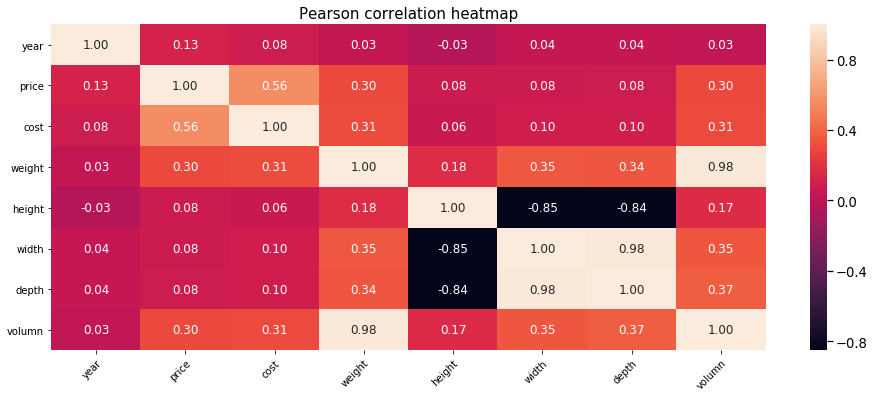

In [18]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
sns.set_context("notebook", font_scale=1.2, rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":18})

ax = sns.heatmap(df.corr("pearson"), annot=True, fmt=".2f")
plt.title("Pearson correlation heatmap")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")  
#ax.set_yticklabels(rotation=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  
#ax.set_xticks(rotation=30)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(8.0, 0.0)

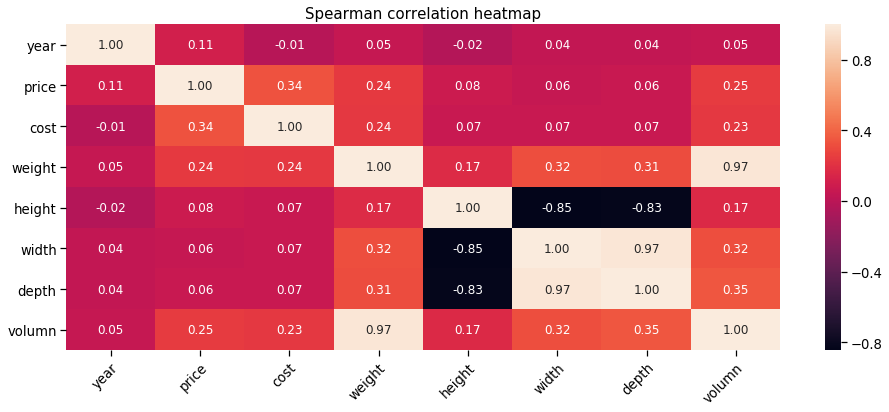

In [19]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
sns.set_context("notebook", font_scale=1.2, rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":18})

ax = sns.heatmap(df.corr("spearman"), annot=True, fmt=".2f")
plt.title("Spearman correlation heatmap")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")  
#ax.set_yticklabels(rotation=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  
#ax.set_xticks(rotation=30)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(8.0, 0.0)

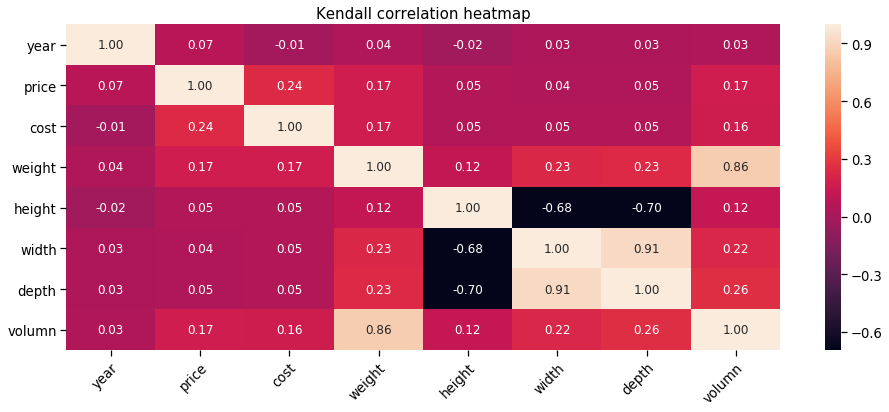

In [20]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
sns.set_context("notebook", font_scale=1.2, rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":18})

ax = sns.heatmap(df.corr("kendall"), annot=True, fmt=".2f")
plt.title("Kendall correlation heatmap")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")  
#ax.set_yticklabels(rotation=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  
#ax.set_xticks(rotation=30)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

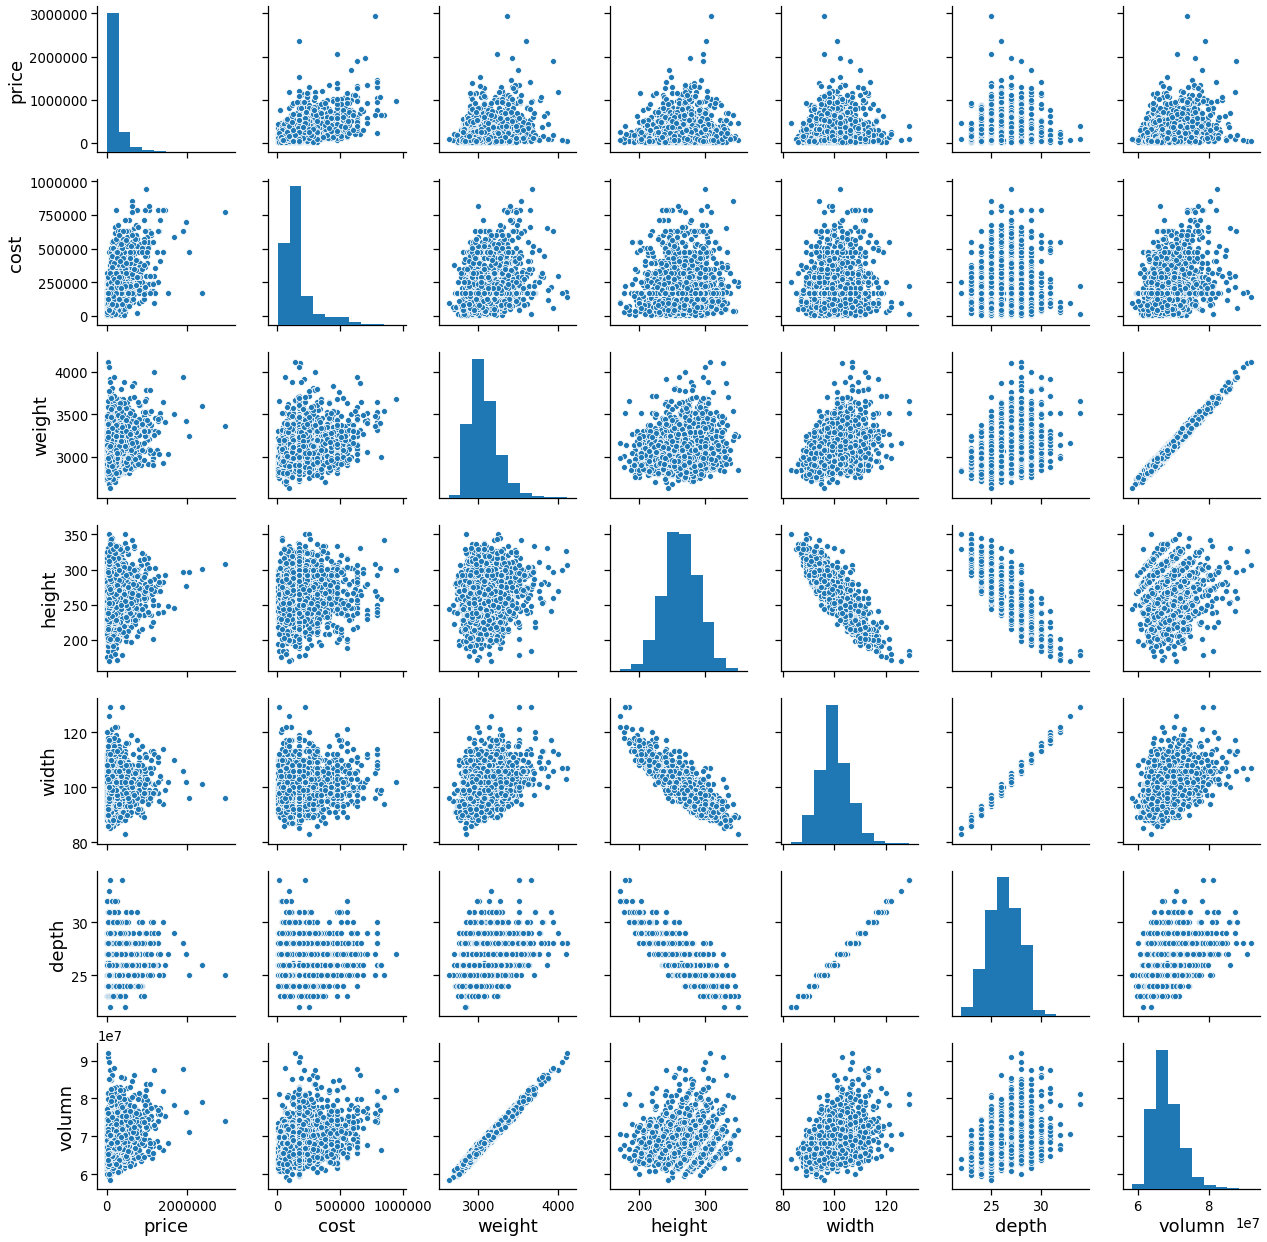

In [21]:
g = sns.pairplot(df.drop("year", axis=1))

# 2. Problem definition: we need to find related variables to predict price; we will need use past data to predict future price.

# 3. Feature engineering

## 3.1 Feature engineering: Backward elimination to find related numerical variables

### <font color='red'>Introduction to feature elimination: </font>Feature elimination can be conducted using (1). All-In, (2). Forward Elimination, (3). Backward Elimination, (4). Bidirectional Elimination, or (5). Score Comparison. The most popular one is Backward Elimination like below: 
Step 1: Select a significance level to stay in the model (<font color='red'>**SL = 0.05**</font>)<br>
step 2: Fit the full model with all possible predictors <br>
step 3: Consider the predictor with the highest p-value . If **<font color='red'>P > SL</font>**, go to step 4, otherwise go to Finish line. <br>
step 4: Remove the predictor <br>
step 5: Fit the model without this variable --> Go To STEP 3 <br>

I will show automatic procedures to do backward elimination with **<font color='red'>p-values ONLY</font>**, or with **<font color='red'>p-values and Adjusted R Squared</font>**<br>
[Source: model performance metrics](http://www.sthda.com/english/articles/38-regression-model-validation/158-regression-model-accuracy-metrics-r-square-aic-bic-cp-and-more/)

In [22]:
train = df[df.year < 2015].reset_index(drop=True)
test = df[df.year >= 2015].reset_index(drop=True)

features = list(df.describe().columns)                   #first to keep numeric varibles only
#features = list(df.columns)
target = 'price'
features.remove(target)
features.remove('year')

# X_train = train[features]
# y_train = train[target]

# X_test = test[features]
# y_test = test_raw[target]
# X_train, y_train

X = df[features].values
y = df[target].values
X = np.append(arr = np.ones((len(X[:,0]), 1)).astype(int), values = X, axis = 1)

In [23]:
X_opt = X[:, [0, 1, 2, 3, 4, 5, 6]]
#X_opt = X[0:1, [0, 1, 2, 3, 4, 5, 6]]
X_opt

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, ...,
        9.70000000e+01, 2.60000000e+01, 6.96072000e+07],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, ...,
        9.80000000e+01, 2.60000000e+01, 6.80316000e+07],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, ...,
        9.30000000e+01, 2.40000000e+01, 6.69600000e+07],
       ...,
       [1.00000000e+00, 1.69019448e+05, 3.08000000e+03, ...,
        9.60000000e+01, 2.50000000e+01, 6.81600000e+07],
       [1.00000000e+00, 4.40000000e+04, 2.95000000e+03, ...,
        1.00000000e+02, 2.60000000e+01, 6.55200000e+07],
       [1.00000000e+00, 1.28000000e+05, 2.98000000e+03, ...,
        9.20000000e+01, 2.40000000e+01, 6.53568000e+07]])

 ## Backward elimination with **<font color='red'>p-values ONLY</font>**

In [24]:
import statsmodels.api as sm
def backwardElimination(y, x, sl):
    numVars = len(x[0,:])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x, regressor_OLS.summary()
 
SL = 0.05
X_opt = X[:, [0, 1, 2, 3, 4, 5, 6]]
#X_opt = X[:, list(range(len(X[0,:])))]
X_Modeled = backwardElimination(y, X_opt, SL)
X_Modeled
# selected columns are 'cost', 'weight'
# you can see all individual p-value for the features is < 0.05

(array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03],
        [1.00000000e+00, 1.69019448e+05, 3.03000000e+03],
        [1.00000000e+00, 2.70000000e+05, 3.04000000e+03],
        ...,
        [1.00000000e+00, 1.69019448e+05, 3.08000000e+03],
        [1.00000000e+00, 4.40000000e+04, 2.95000000e+03],
        [1.00000000e+00, 1.28000000e+05, 2.98000000e+03]]),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.332
 Model:                            OLS   Adj. R-squared:                  0.332
 Method:                 Least Squares   F-statistic:                     791.1
 Date:                Fri, 24 Apr 2020   Prob (F-statistic):          1.22e-279
 Time:                        19:26:18   Log-Likelihood:                -43077.
 No. Observations:                3186   AIC:                         8.616e+04
 Df Residuals:             

 ## backward elimination with **<font color='red'>p-values and Adjusted R Squared</font>**

In [25]:
import statsmodels.api as sm

def backwardElimination(x, SL):
    numVars = len(x[0,:])
    temp = np.zeros((len(X_opt[:,0]),len(X_opt[0,:]))).astype(int)
    for i in range(0, numVars):
        #regressor_OLS  = sm.ols(formula='Y ~ X', data=df2).fit()
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x
 
SL = 0.05
X_opt = X[:, [0, 1, 2, 3, 4, 5, 6]]
X_Modeled = backwardElimination(X_opt, SL)
X_Modeled
# selected columns are 'cost', 'weight', 'width', 'depth'
# you can see not all individual p-value for the features is < 0.05, because that one should have contributed to adjusted R2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     397.0
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          1.06e-277
Time:                        19:26:19   Log-Likelihood:                -43075.
No. Observations:                3186   AIC:                         8.616e+04
Df Residuals:                    3181   BIC:                         8.619e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.309e+05   6.97e+04     -6.183      0.0

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 9.70000000e+01,
        2.60000000e+01],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 9.80000000e+01,
        2.60000000e+01],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 9.30000000e+01,
        2.40000000e+01],
       ...,
       [1.00000000e+00, 1.69019448e+05, 3.08000000e+03, 9.60000000e+01,
        2.50000000e+01],
       [1.00000000e+00, 4.40000000e+04, 2.95000000e+03, 1.00000000e+02,
        2.60000000e+01],
       [1.00000000e+00, 1.28000000e+05, 2.98000000e+03, 9.20000000e+01,
        2.40000000e+01]])

 <font color='red'>Comments</font>.: from correlation heatmap, width is correlated with height and depth, and column. From the backward elimination, especially with result from adjusted R2, it shows width can enhance the model metrics. So, my take from here is that AMONG width, depth, height, and volumn, we ONLY need to keep<font color='red'> width and depth</font>.

## 3.2 Feature engineering: Backward elimination -- numerical variables + categorical variables

 <font color='red'>Add categorical variables "product_level" and "maker"  to X</font>

In [26]:
#features = list(df.describe().columns)                   #first to keep numeric varibles only
features = list(df.columns)
target = 'price'
features.remove(target)
features.remove('year')
features.remove('purchase_date')
features.remove('product_type')
features.remove('ingredient')
features.remove('maker')

X = df[features].values
y = df[target].values
X = np.append(arr = np.ones((len(X[:,0]), 1)).astype(int), values = X, axis = 1)
X[0, :]

array([1, 333000.0, 3090.0, 276.0, 97.0, 26.0, 69607200.0, 'advanced'],
      dtype=object)

In [27]:
df.product_level.unique()

array(['advanced', 'basic', 'super advanced', 'intermediate', 'unrated'],
      dtype=object)

In [28]:
X[:,7].reshape(-1, 1)

array([['advanced'],
       ['basic'],
       ['basic'],
       ...,
       ['intermediate'],
       ['advanced'],
       ['super advanced']], dtype=object)

In [29]:
from sklearn.preprocessing import OneHotEncoder
enc =  OneHotEncoder()
product_imp = enc.fit_transform(df.product_level.values.reshape(-1, 1)).toarray()
product_imp.shape

(3186, 5)

In [30]:
df.product_level.head(20)


0           advanced
1              basic
2              basic
3           advanced
4           advanced
5     super advanced
6     super advanced
7           advanced
8     super advanced
9           advanced
10    super advanced
11          advanced
12    super advanced
13          advanced
14          advanced
15    super advanced
16    super advanced
17          advanced
18      intermediate
19          advanced
Name: product_level, dtype: object

In [31]:
prd_enc=pd.DataFrame(product_imp, columns =(list(df.product_level.unique())) )         # columns =(enc.categories_)
prd_enc=prd_enc.drop('unrated', axis=1)             # remove one dummy variable to avoid the Dummy Variable Trap
prd_enc.shape
prd_enc.head()

,advanced,basic,super advanced,intermediate
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [32]:
df.maker.map(lambda x: 'Missing' if x is np.nan else x).unique()


array(['M14122', 'Missing', 'M14123', 'M14124', 'M14125', 'M14126',
       'M14127', 'M14128', 'M14129', 'M14130', 'M14131', 'M14132',
       'M14133', 'M14134,M14135', 'M14136', 'M14137', 'M14138,M14139',
       'M14140', 'M14141', 'M14142', 'M14143', 'M14144', 'M14145',
       'M14146', 'M14147', 'M14148', 'M14149', 'M14150', 'M14151',
       'M14152', 'M14153', 'M14154', 'M14155', 'M14156', 'M14157',
       'M14158', 'M14159', 'M14160', 'M14161', 'M14162', 'M14163',
       'M14164', 'M14165', 'M14166', 'M14167', 'M14168', 'M14169',
       'M14170', 'M14171', 'M14172', 'M14173', 'M14174', 'M14175',
       'M14176', 'M14177', 'M14178', 'M14179', 'M14180', 'M14181',
       'M14182', 'M14183', 'M14184', 'M14185', 'M14186', 'M14187',
       'M14188', 'M14189', 'M14190', 'M14191', 'M14192', 'M14193,M14194',
       'M14195', 'M14196', 'M14197', 'M14198,M14199', 'M14200', 'M14201',
       'M14202', 'M14194', 'M14203', 'M14204', 'M14205', 'M14206',
       'M14207', 'M14208', 'M14209', 'M1421

In [33]:
maker_imp = enc.fit_transform(df.maker.map(lambda x: 'Missing' if x is np.nan else x).values.reshape(-1, 1)).toarray()
maker_imp = maker_imp[:, 1:]        # Avoiding the Dummy Variable Trap
maker_imp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
columns =(enc.categories_)
columns = np.delete(columns, 0)              # remove('M14122') to avoid Dummy Variable Trap
#columns

In [35]:
maker_enc=pd.DataFrame(maker_imp, columns =(columns))    
maker_enc

,M14123,M14124,M14125,M14126,M14127,M14128,M14129,M14130,M14131,M14132,...,M15004,M15005,M15006,M15007,M15008,M15009,M15010,M15011,M15012,Missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### combine numerical variables and transformed dummy variables for catigoricals

In [36]:
df_cc = df.drop(['year', 'purchase_date', 'product_type', 'product_level', 'maker', 'ingredient'], axis=1)
df_cc.reset_index(drop=True)
df_cc.columns
df_cc.shape
df_cc.reset_index(drop=True)
df_cc.index

RangeIndex(start=0, stop=3186, step=1)

In [37]:
df_cc = pd.concat([df_cc, prd_enc, maker_enc ], axis=1)
df_cc.head()
df_cc.shape


(3186, 890)

In [38]:

features = list(df_cc.describe().columns)                   #first to keep numeric varibles only
#features = list(df.columns)
target = 'price'
features.remove(target)

X = df_cc[features].values
y = df_cc[target].values
X = np.append(arr = np.ones((len(X[:,0]), 1)).astype(int), values = X, axis = 1)

In [39]:
X.shape

(3186, 890)

In [ ]:
rng = list(i for i in range(X.shape[1]))
#rng

In [ ]:
X_opt = X[:, rng]
#X_opt

## Backward elimination variables in re-combined data with **<font color='red'>p-values ONLY</font>**

In [461]:
import statsmodels.api as sm
def backwardElimination(y, x, sl):
    numVars = len(x[0,:])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x, regressor_OLS.summary()
 
SL = 0.05
X_opt = X[:, rng]
#X_opt = X[0:1, rng]
X_Modeled = backwardElimination(y, X_opt, SL)
X_Modeled
# 96 features selected, maybe need quite some time to figure out, at least I cannot finish this for this homework.
# you can see all p-value for the feature is < 0.05

(array([[1.00000000e+00, 3.33000000e+05, 6.96072000e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.69019448e+05, 6.80316000e+07, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 2.70000000e+05, 6.69600000e+07, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        ...,
        [1.00000000e+00, 1.69019448e+05, 6.81600000e+07, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 4.40000000e+04, 6.55200000e+07, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.28000000e+05, 6.53568000e+07, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.596
 Model:                            OLS   Adj. R-squared

In [ ]:
X_Modeled[1]

## Backward elimination with **<font color='red'>p-values and Adjusted R Squared</font>**

In [452]:
import statsmodels.api as sm

def backwardElimination(x, SL):
    numVars = len(x[0,:])
    temp = np.zeros((len(X_opt[:,0]),len(X_opt[0,:]))).astype(int)
    for i in range(0, numVars):
        #regressor_OLS  = sm.ols(formula='Y ~ X', data=df2).fit()
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x
 
SL = 0.05
X_opt = X[:, rng]
X_Modeled = backwardElimination(X_opt, SL)
X_Modeled
# 255 features selected, maybe need quite some time to figure out, at least I cannot finish this for this homework.
# you can see not all individual p-value for the features is < 0.05, because that one should have contributed to adjusted R2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     19.83
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:44:56   Log-Likelihood:                -42123.
No. Observations:                3186   AIC:                         8.476e+04
Df Residuals:                    2930   BIC:                         8.631e+04
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.421e+05   6.04e+04     -7.318      0.0

array([[1.00000000e+00, 3.33000000e+05, 2.60000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 2.60000000e+01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.70000000e+05, 2.40000000e+01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.69019448e+05, 2.50000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.40000000e+04, 2.60000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.28000000e+05, 2.40000000e+01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## <font color='red'>Now only use numeric variables plus dummy variables for "product_level"</font>

In [42]:
df_cc2 = df.drop(['year', 'purchase_date', 'product_type', 'product_level', 'maker', 'ingredient'], axis=1)
df_cc2.reset_index(drop=True)
df_cc2.columns
df_cc2.shape
df_cc2.reset_index(drop=True)
df_cc2.index

RangeIndex(start=0, stop=3186, step=1)

In [43]:
df_cc2 = pd.concat([df_cc2, prd_enc], axis=1)
df_cc2.head()
df_cc2.shape

(3186, 11)

In [44]:
features = list(df_cc2.describe().columns)                   #first to keep numeric varibles only
#features = list(df.columns)
target = 'price'
features.remove(target)

X = df_cc2[features].values
y = df_cc2[target].values
X = np.append(arr = np.ones((len(X[:,0]), 1)).astype(int), values = X, axis = 1)

X.shape

(3186, 11)

In [45]:
rng = list(i for i in range(X.shape[1]))
rng

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [46]:
X_opt = X[:, rng]
#X_opt = X[0:1, rng]
X_opt

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.69019448e+05, 3.08000000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.40000000e+04, 2.95000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.28000000e+05, 2.98000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## Backward elimination with **<font color='red'>p-values ONLY</font>**

In [47]:
import statsmodels.api as sm
def backwardElimination(y, x, sl):
    numVars = len(x[0,:])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x, regressor_OLS.summary()
 
SL = 0.05
X_opt = X[:, rng]
#X_opt = X[0:1, rng]
X_Modeled = backwardElimination(y, X_opt, SL)
X_Modeled
# 5 features selected, selected columns are 'cost', 'weight', 'advanced', 'basic', 'super advanced'
# you can see all p-value for the feature is < 0.05

(array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 1.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 0.00000000e+00,
         1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 0.00000000e+00,
         1.00000000e+00, 0.00000000e+00],
        ...,
        [1.00000000e+00, 1.69019448e+05, 3.08000000e+03, 0.00000000e+00,
         0.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 4.40000000e+04, 2.95000000e+03, 1.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.28000000e+05, 2.98000000e+03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00]]),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.343
 Model:                            OLS   Adj. R-squared:                  0.342
 Meth

In [48]:
### compare X from model outcome with X from input to see which vaiable is selected

In [49]:
X_Modeled[0][0:6,:]

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.05000000e+03, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.70000000e+04, 2.97000000e+03, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.90000000e+04, 2.93000000e+03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [50]:
X_opt = X[0:6, rng]
X_opt

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 2.76000000e+02,
        9.70000000e+01, 2.60000000e+01, 6.96072000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 2.67000000e+02,
        9.80000000e+01, 2.60000000e+01, 6.80316000e+07, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 3.00000000e+02,
        9.30000000e+01, 2.40000000e+01, 6.69600000e+07, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.05000000e+03, 2.50000000e+02,
        1.02000000e+02, 2.70000000e+01, 6.88500000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.70000000e+04, 2.97000000e+03, 2.47000000e+02,
        1.01000000e+02, 2.60000000e+01, 6.48622000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

## Backward elimination with **<font color='red'>p-values and Adjusted R Squared</font>**

In [51]:
import statsmodels.api as sm

def backwardElimination(x, SL):
    numVars = len(x[0,:])
    temp = np.zeros((len(X_opt[:,0]),len(X_opt[0,:]))).astype(int)
    for i in range(0, numVars):
        #regressor_OLS  = sm.ols(formula='Y ~ X', data=df2).fit()
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x
 
SL = 0.05
X_opt = X[:, rng]
X_Modeled = backwardElimination(X_opt, SL)
X_Modeled
# 7 features selected, the following variables (features) are selected: 'cost', 'weight', 'width',  'basic', 'super advanced', 'intermediate'.
# you can see not all individual p-value for the features is < 0.05, because that one should have contributed to adjusted R2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     238.0
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          2.86e-285
Time:                        19:28:20   Log-Likelihood:                -43048.
No. Observations:                3186   AIC:                         8.611e+04
Df Residuals:                    3178   BIC:                         8.616e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.591e+05   7.18e+04     -7.781      0.0

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 2.40000000e+01],
       ...,
       [1.00000000e+00, 1.69019448e+05, 3.08000000e+03, ...,
        1.00000000e+00, 0.00000000e+00, 2.50000000e+01],
       [1.00000000e+00, 4.40000000e+04, 2.95000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 1.28000000e+05, 2.98000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 2.40000000e+01]])

In [52]:
### compare X from model outcome with X from input to see which vaiable is selected

In [53]:
X_Modeled[0:6,:]

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 9.70000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 9.80000000e+01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 9.30000000e+01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40000000e+01],
       [1.00000000e+00, 1.69019448e+05, 3.05000000e+03, 1.02000000e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.70000000e+01],
       [1.00000000e+00, 9.70000000e+04, 2.97000000e+03, 1.01000000e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.60000000e+01],
       [1.00000000e+00, 5.90000000e+04, 2.93000000e+03, 9.60000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000000e+01]])

In [54]:
X_opt = X[0:6, rng]
X_opt
# array(['advanced', 'basic', 'super advanced', 'intermediate', 'unrated']     #'unrated' is removed from model

array([[1.00000000e+00, 3.33000000e+05, 3.09000000e+03, 2.76000000e+02,
        9.70000000e+01, 2.60000000e+01, 6.96072000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.03000000e+03, 2.67000000e+02,
        9.80000000e+01, 2.60000000e+01, 6.80316000e+07, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.70000000e+05, 3.04000000e+03, 3.00000000e+02,
        9.30000000e+01, 2.40000000e+01, 6.69600000e+07, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.69019448e+05, 3.05000000e+03, 2.50000000e+02,
        1.02000000e+02, 2.70000000e+01, 6.88500000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.70000000e+04, 2.97000000e+03, 2.47000000e+02,
        1.01000000e+02, 2.60000000e+01, 6.48622000e+07, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

## 3.3 Feature engineering: summary

By Backward Elimination with numerical variables and two categorical variables, I found 6 variables related to price. For the nextmodeling, I will use dataframe df_cc2 (continuous variable and dummies from product_level) with only the features selected by adjusted R squared + p-value, i.e., <font color='green'>'cost', 'weight', 'width',  'basic', 'super advanced', 'intermediate'</font>.

In [55]:
df_a = pd.concat([df_cc2, df['year'] ], axis=1)

In [56]:
df_a.head()

,price,cost,weight,height,width,depth,volumn,advanced,basic,super advanced,intermediate,year
0,300492.0,333000.000000,3090.0,276.0,97.0,26.0,69607200.0,1.0,0.0,0.0,0.0,2008
1,430570.0,169019.448213,3030.0,267.0,98.0,26.0,68031600.0,0.0,1.0,0.0,0.0,1997
2,213070.0,270000.000000,3040.0,300.0,93.0,24.0,66960000.0,0.0,1.0,0.0,0.0,2001
3,229174.0,169019.448213,3050.0,250.0,102.0,27.0,68850000.0,1.0,0.0,0.0,0.0,2016
4,122659.0,97000.000000,2970.0,247.0,101.0,26.0,64862200.0,1.0,0.0,0.0,0.0,2000


In [57]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 12 columns):
price             3186 non-null float64
cost              3186 non-null float64
weight            3186 non-null float64
height            3186 non-null float64
width             3186 non-null float64
depth             3186 non-null float64
volumn            3186 non-null float64
advanced          3186 non-null float64
basic             3186 non-null float64
super advanced    3186 non-null float64
intermediate      3186 non-null float64
year              3186 non-null int64
dtypes: float64(11), int64(1)
memory usage: 298.8 KB


In [58]:
df_a.describe()

,price,cost,weight,height,width,depth,volumn,advanced,basic,super advanced,intermediate,year
count,3.186000e+03,3186.000000,3186.000000,3186.000000,3186.00000,3186.000000,3.186000e+03,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000
mean,1.823176e+05,169019.448213,3072.208294,262.858624,99.88847,26.181904,6.828061e+07,0.414313,0.034840,0.166981,0.383553,2006.871626
std,2.205118e+05,121141.273787,179.019306,27.044892,5.53327,1.478860,4.047812e+06,0.492680,0.183403,0.373017,0.486327,6.008380
min,3.131000e+03,3000.000000,2630.000000,170.000000,83.00000,22.000000,5.856000e+07,0.000000,0.000000,0.000000,0.000000,1996.000000
25%,5.154075e+04,88000.000000,2950.000000,245.000000,96.00000,25.000000,6.537960e+07,0.000000,0.000000,0.000000,0.000000,2002.000000
50%,1.105225e+05,169019.448213,3040.000000,262.000000,99.00000,26.000000,6.767040e+07,0.000000,0.000000,0.000000,0.000000,2007.000000
75%,2.226220e+05,176000.000000,3170.000000,281.000000,103.00000,27.000000,7.049828e+07,1.000000,0.000000,0.000000,1.000000,2012.000000
max,2.945329e+06,945000.000000,4120.000000,350.000000,129.00000,34.000000,9.197720e+07,1.000000,1.000000,1.000000,1.000000,2017.000000


In [59]:
# features selected from the last round: 'cost', 'weight', 'width',  'basic', 'super advanced', 'intermediate'
features = list(df_a.describe().columns) 
features

['price',
 'cost',
 'weight',
 'height',
 'width',
 'depth',
 'volumn',
 'advanced',
 'basic',
 'super advanced',
 'intermediate',
 'year']

In [60]:
target = 'price'
#features.remove(target)
features = [ elem for elem in features if elem in ['cost', 'weight', 'width',  'basic', 'super advanced', 'intermediate']]
target = 'price'
features

['cost', 'weight', 'width', 'basic', 'super advanced', 'intermediate']

In [61]:
train = df_a[df_a.year < 2015].reset_index(drop=True)
test = df_a[df_a.year >= 2015].reset_index(drop=True)
train.shape, test.shape
train

,price,cost,weight,height,width,depth,volumn,advanced,basic,super advanced,intermediate,year
0,300492.0,333000.000000,3090.0,276.0,97.0,26.0,69607200.0,1.0,0.0,0.0,0.0,2008
1,430570.0,169019.448213,3030.0,267.0,98.0,26.0,68031600.0,0.0,1.0,0.0,0.0,1997
2,213070.0,270000.000000,3040.0,300.0,93.0,24.0,66960000.0,0.0,1.0,0.0,0.0,2001
3,122659.0,97000.000000,2970.0,247.0,101.0,26.0,64862200.0,1.0,0.0,0.0,0.0,2000
4,60320.0,59000.000000,2930.0,271.0,96.0,25.0,65040000.0,0.0,0.0,0.0,1.0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
2752,255179.0,254000.000000,3040.0,202.0,113.0,30.0,68478000.0,0.0,0.0,1.0,0.0,2012
2753,144631.0,91000.000000,2890.0,252.0,99.0,26.0,64864800.0,1.0,0.0,0.0,0.0,2002
2754,40384.0,169019.448213,2830.0,215.0,106.0,28.0,63812000.0,0.0,0.0,1.0,0.0,2007
2755,55931.0,44000.000000,2950.0,252.0,100.0,26.0,65520000.0,1.0,0.0,0.0,0.0,2002


In [62]:
X_train = train[features] #train[['cost']]
y_train = train[target]

X_test = test[features] #test[['cost']]
y_test = test[target]

XX =  train[features]
yy =  train[target]

# 4. Modeling

## 4.1 Modeling: Regular Linear Regression

In [63]:
MAEc =dict()

In [64]:
MSEc = dict()

In [65]:
R2c = dict()

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

steps = [('Rescale', MinMaxScaler()),
         ('lr', LinearRegression()),  ]
model = Pipeline(steps)

model.fit(X_train, y_train)
model[1].coef_, model[1].intercept_

(array([786954.88746601, 324534.4000321 , -45422.4155575 ,  54060.59354896,
         11232.32756709, -41112.47658254]), -26360.047860798164)

<font color='red'> Calculate the train/test scores. </font>

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

Train Loss | 	MAE: 1.14e+05	MSE:  2.82e+10	R^2:  0.3373
Test  Loss | 	MAE: 1.42e+05	MSE:  5.59e+10	R^2:  0.3514


In [68]:
MAEc['olstr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['olstr'] = mean_squared_error(y_train, y_train_pred);
R2c['olstr'] = r2_score(y_train, y_train_pred)
MAEc['olste']=mean_absolute_error(y_test, y_test_pred); 
MSEc['olste'] = mean_squared_error(y_test, y_test_pred);
R2c['olste'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588, 'olste': 142142.36264466285},
 {'olstr': 28237461541.996464, 'olste': 55916714076.703},
 {'olstr': 0.3373329188304307, 'olste': 0.3513977202108557})

<font color='red'>Plot the relationship between price and cost.</font> 

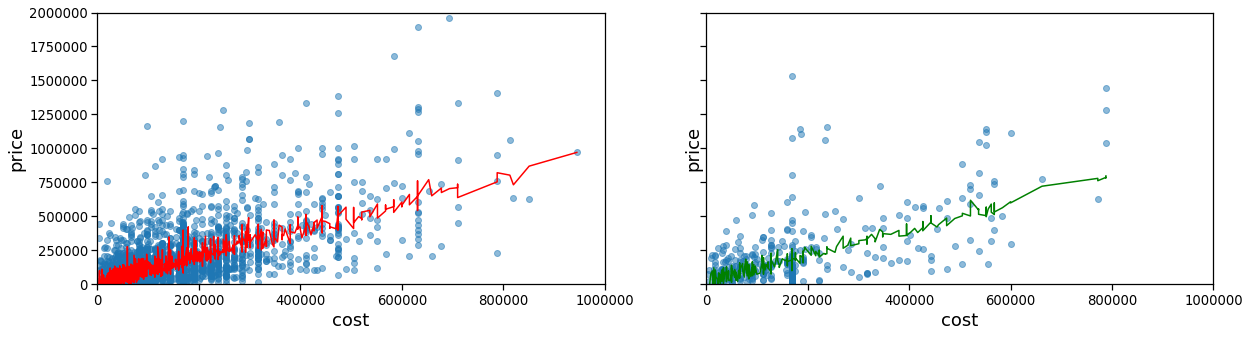

In [69]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

 ## 4.2 Modeling: Lasso

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

steps = [('Rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=1,max_iter = 1000000)), ]           # in following test, only alpha=100000 has horizontal line
model = Pipeline(steps)

model.fit(X_train, y_train)
model[1].coef_, model[1].intercept_

(array([786916.50761827, 324425.62416167, -45315.4965448 ,  54023.88135046,
         11220.72911935, -41114.11407943]), -26356.384002317413)

<font color='red'> Calculate the train/test scores. </font>

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [72]:
print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

Train Loss | 	MAE: 1.14e+05	MSE:  2.82e+10	R^2:  0.3373
Test  Loss | 	MAE: 1.42e+05	MSE:  5.59e+10	R^2:  0.3514


In [73]:
MAEc['lassotr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['lassotr'] = mean_squared_error(y_train, y_train_pred);
R2c['lassotr'] = r2_score(y_train, y_train_pred)
MAEc['lassote']=mean_absolute_error(y_test, y_test_pred); 
MSEc['lassote'] = mean_squared_error(y_test, y_test_pred);
R2c['lassote'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.3513912644869379})

<font color='red'>Plot the relationship between price and cost.</font> 

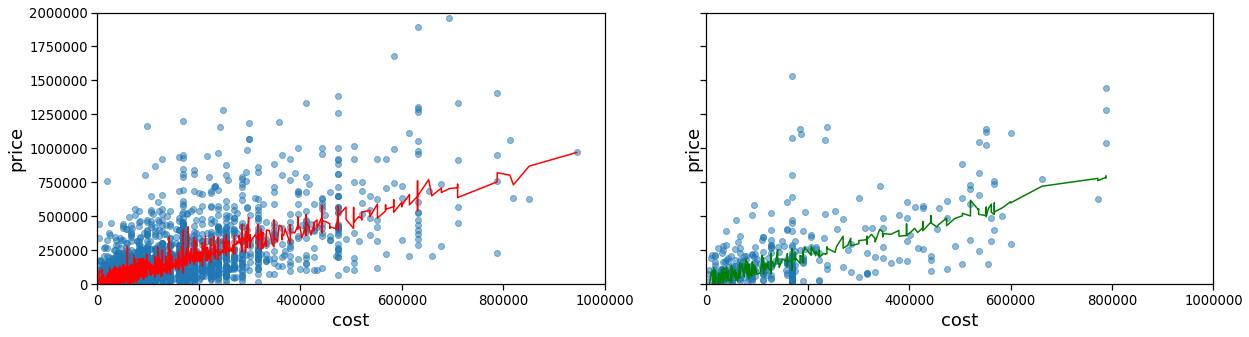

In [74]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

# The effect of alpha on metrics

alpha = 0.01 ...
alpha = 0.05994842503189409 ...
alpha = 0.35938136638046275 ...
alpha = 2.1544346900318843 ...
alpha = 12.91549665014884 ...
alpha = 77.4263682681127 ...
alpha = 464.1588833612782 ...
alpha = 2782.559402207126 ...
alpha = 16681.005372000593 ...
alpha = 100000.0 ...


(0, 2000000.0)

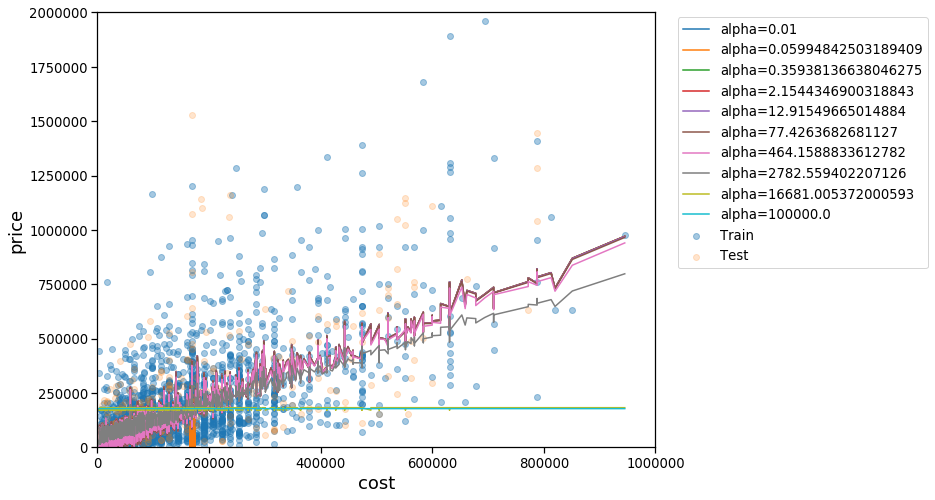

In [75]:
train_MAEs, train_MSEs, train_r2s = [], [], []
test_MAEs, test_MSEs, test_r2s = [], [], []
coefs = []

#alphas = np.logspace(-2, 1, 5, True, 10)
alphas = np.logspace(-2, 5, 10, True, 10)
#alphas = [0.2, 0.3, 0.5, 1, 2, 5, 10, 100]
# Plot train & test
plt.figure(figsize=(10,8))
plt.scatter(X_train['cost'].values, y_train.values, alpha=0.4, label='Train')
plt.scatter(X_test['cost'].values, y_test, alpha=0.2, label='Test')
x = pd.DataFrame(np.linspace(0, 1e6), columns=['cost'])

for alpha in alphas:
    print(f'alpha = {alpha} ...')
    steps = [('Rescale', MinMaxScaler()),
             ('lasso', Lasso(alpha=alpha,max_iter = 1000000)), ]
    
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    coefs.append(model[-1].coef_) 

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # put predicted values paired with X in same dataFrame for plotting
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_new = pd.concat([X_train_new.reset_index(drop=True), X_test_new.reset_index(drop=True)], ignore_index=True)
    X_new = X_new.sort_values(by='cost')
    
    plt.plot(X_new['cost'].values, X_new['y_pred'].values,  label='alpha='+str(alpha))
    #y = model.predict(x)
    #plt.plot(x, y, label='alpha='+str(alpha))
    
    train_MAEs.append(mean_absolute_error(y_train, y_train_pred))
    train_MSEs.append(mean_squared_error(y_train, y_train_pred))
    train_r2s.append(r2_score(y_train, y_train_pred))
    
    test_MAEs.append(mean_absolute_error(y_test, y_test_pred))
    test_MSEs.append(mean_squared_error(y_test, y_test_pred))
    test_r2s.append(r2_score(y_test, y_test_pred))
    
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.xlabel('cost')
plt.ylabel('price')
plt.xlim([0, 1e6])
plt.ylim([0, 2e6])

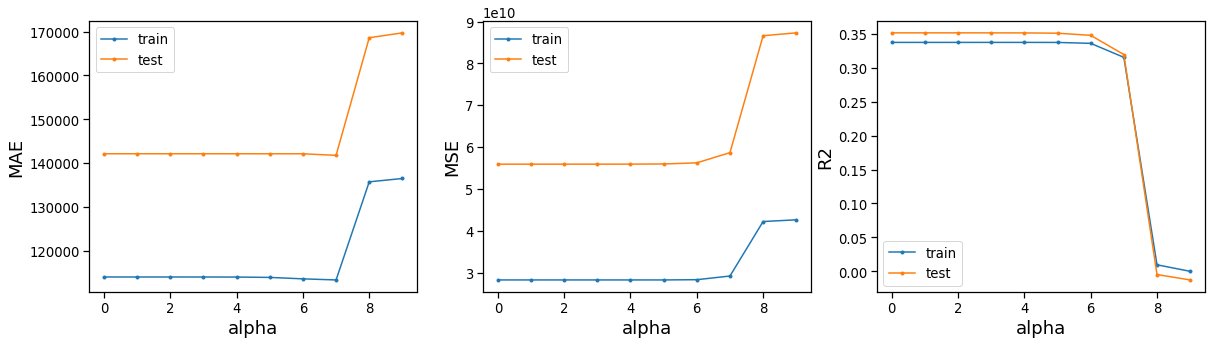

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5), sharex=True)
ax1.plot(train_MAEs,'.-')
ax1.plot(test_MAEs,'.-')
ax1.set_xlabel('alpha')
ax1.set_ylabel('MAE');
ax1.legend(['train', 'test'])

ax2.plot(train_MSEs,'.-')
ax2.plot(test_MSEs,'.-')
ax2.set_xlabel('alpha')
ax2.set_ylabel('MSE');
ax2.legend(['train', 'test'])

ax3.plot(train_r2s,'.-')
ax3.plot(test_r2s,'.-')
ax3.set_xlabel('alpha')
ax3.set_ylabel('R2');
ax3.legend(['train', 'test'])

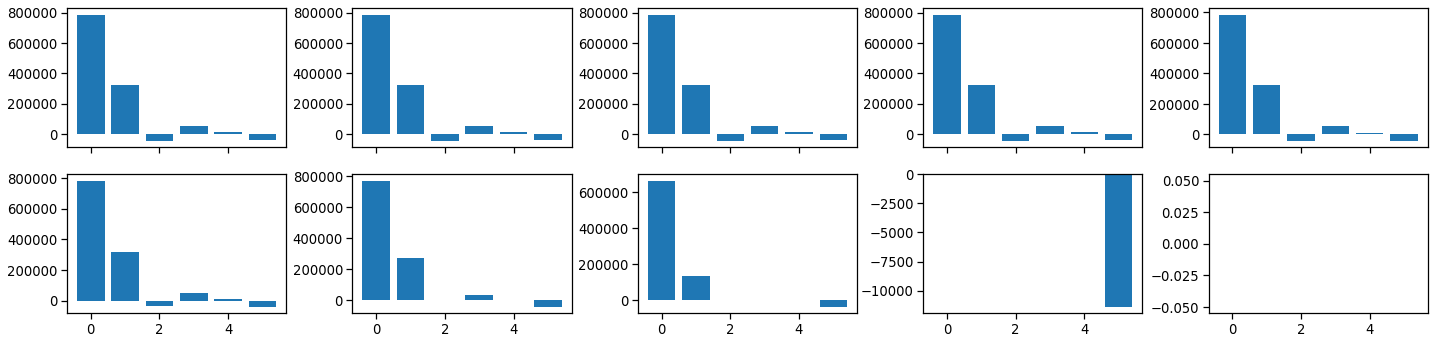

In [77]:
fig, axes = plt.subplots(2,5, figsize=(20,5),sharex=True)
axes = axes.ravel()
plt.tight_layout()
for i, ax in enumerate(axes):
    ax.bar(range(6), coefs[i])

#ax.set_yscale('log')

In [78]:
coefs

[array([786954.52065407, 324533.29881668, -45421.34615643,  54060.22332151,
         11232.21029967, -41112.49223937]),
 array([786952.63674676, 324527.83961488, -45416.00529884,  54058.38371132,
         11231.62857814, -41112.57259789]),
 array([786941.26220754, 324495.20636907, -45383.98710968,  54047.39319595,
         11228.16220781, -41113.05309515]),
 array([786873.02525836, 324299.78697109, -45192.03442572,  53981.64888062,
         11207.47201516, -41115.90853571]),
 array([786453.34518079, 323136.02107221, -44041.47339738,  53588.95502668,
         11083.90980895, -41133.57811419]),
 array([784023.67647798, 316103.87697581, -37142.30139821,  51228.84646176,
         10343.02036203, -41233.86510826]),
 array([769361.49790674, 275469.63801234,     -0.        ,  37096.17125025,
          5892.35474694, -41834.53067093]),
 array([666074.37520063, 135409.77023989,      0.        ,      0.        ,
             0.        , -37889.9770305 ]),
 array([     0.        ,      0.        

 <font color='blue' size =4>Above tests demonstrate what WE learned in previous class that all coefficients go to 0's when alpha is big enough (here it's 1.0E05); # when alpha is less than 500, it's effects on loss functions or variance is not significant</font>

 ## 4.3 Modeling: Ridge

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

steps = [('Rescale', MinMaxScaler()),
         ('Ridge', Ridge(alpha=1, max_iter=10000)), ]           
model = Pipeline(steps)

model.fit(X_train, y_train)
model[1].coef_, model[1].intercept_

(array([768610.64024056, 321057.93504794, -41371.73128975,  53397.06533107,
         11345.40078145, -42003.05320492]), -23274.318437136273)

<font color='red'> Calculate the train/test scores. </font>

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [81]:
print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

Train Loss | 	MAE: 1.14e+05	MSE:  2.82e+10	R^2:  0.3372
Test  Loss | 	MAE: 1.42e+05	MSE:  5.61e+10	R^2:  0.3490


In [82]:
MAEc['ridgetr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['ridgetr'] = mean_squared_error(y_train, y_train_pred);
R2c['ridgetr'] = r2_score(y_train, y_train_pred)
MAEc['ridgete']=mean_absolute_error(y_test, y_test_pred); 
MSEc['ridgete'] = mean_squared_error(y_test, y_test_pred);
R2c['ridgete'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051,
  'ridgetr': 113813.42623932038,
  'ridgete': 141991.96312083106},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408,
  'ridgetr': 28243040089.24211,
  'ridgete': 56125458064.16162},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.3513912644869379,
  'ridgetr': 0.33720200339332806,
  'ridgete': 0.34897640793609985})

<font color='red'>Plot the relationship between price and cost.</font> 

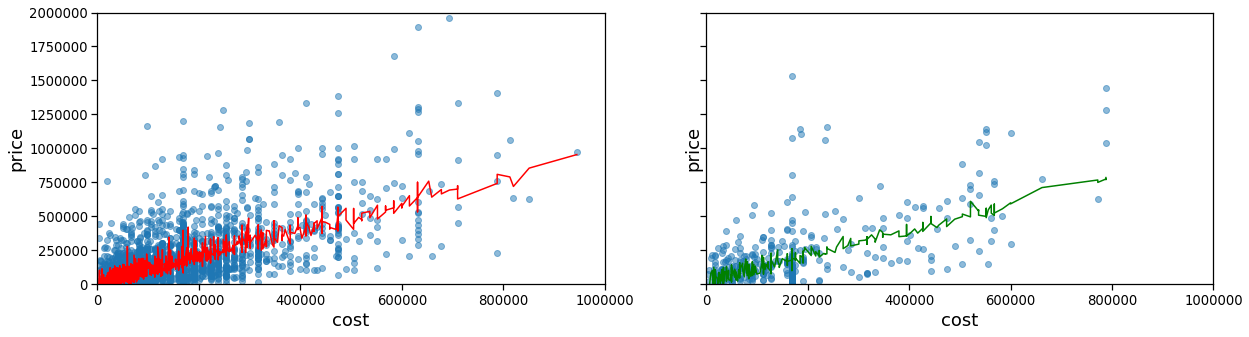

In [83]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

# The effect of alpha on metrics

alpha = 0.04 ...
alpha = 0.13986315735311247 ...
alpha = 0.48904256961953774 ...
alpha = 1.7099759466766975 ...
alpha = 5.9790658725020105 ...
alpha = 20.906275773759337 ...
alpha = 73.10044345532168 ...
alpha = 255.60147063934897 ...
alpha = 893.7307176929556 ...
alpha = 3125.0 ...


(0, 2000000.0)

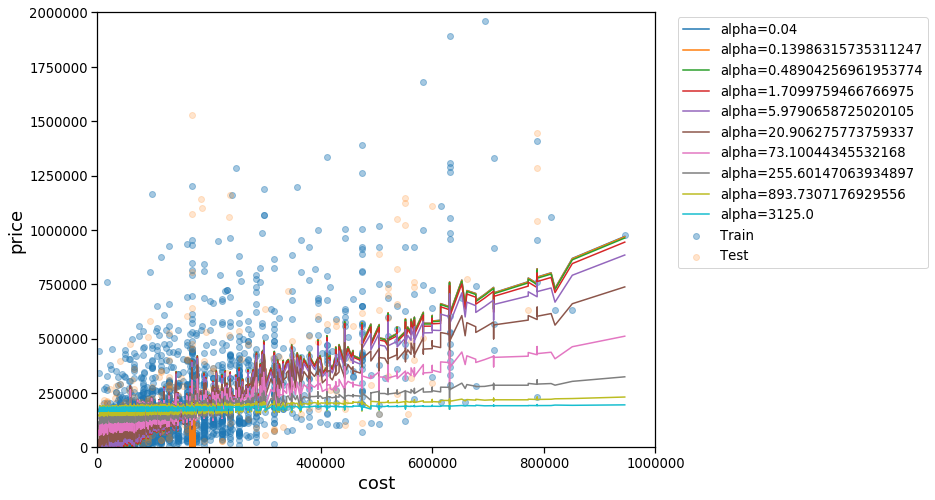

In [84]:
train_MAEs, train_MSEs, train_r2s = [], [], []
test_MAEs, test_MSEs, test_r2s = [], [], []
coefs = []

#alphas = np.logspace(-2, 1, 5, True, 10)
alphas = np.logspace(-2, 5, 10, True, 5)
#alphas = [0.2, 0.3, 0.5, 1, 2, 5, 10, 100]
# Plot train & test
plt.figure(figsize=(10,8))
plt.scatter(X_train['cost'].values, y_train.values, alpha=0.4, label='Train')
plt.scatter(X_test['cost'].values, y_test, alpha=0.2, label='Test')
x = pd.DataFrame(np.linspace(0, 1e6), columns=['cost'])

for alpha in alphas:
    print(f'alpha = {alpha} ...')
    steps = [('Rescale', MinMaxScaler()),
             ('ridge', Ridge(alpha=alpha, max_iter=10000)), ]
    
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    coefs.append(model[-1].coef_) 

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # put predicted values paired with X in same dataFrame for plotting
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_new = pd.concat([X_train_new.reset_index(drop=True), X_test_new.reset_index(drop=True)], ignore_index=True)
    X_new = X_new.sort_values(by='cost')
    
    plt.plot(X_new['cost'].values, X_new['y_pred'].values,  label='alpha='+str(alpha))
    #y = model.predict(x)
    #plt.plot(x, y, label='alpha='+str(alpha))
    
    train_MAEs.append(mean_absolute_error(y_train, y_train_pred))
    train_MSEs.append(mean_squared_error(y_train, y_train_pred))
    train_r2s.append(r2_score(y_train, y_train_pred))
    
    test_MAEs.append(mean_absolute_error(y_test, y_test_pred))
    test_MSEs.append(mean_squared_error(y_test, y_test_pred))
    test_r2s.append(r2_score(y_test, y_test_pred))
    
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.7))
plt.xlabel('cost')
plt.ylabel('price')
plt.xlim([0, 1e6])
plt.ylim([0, 2e6])

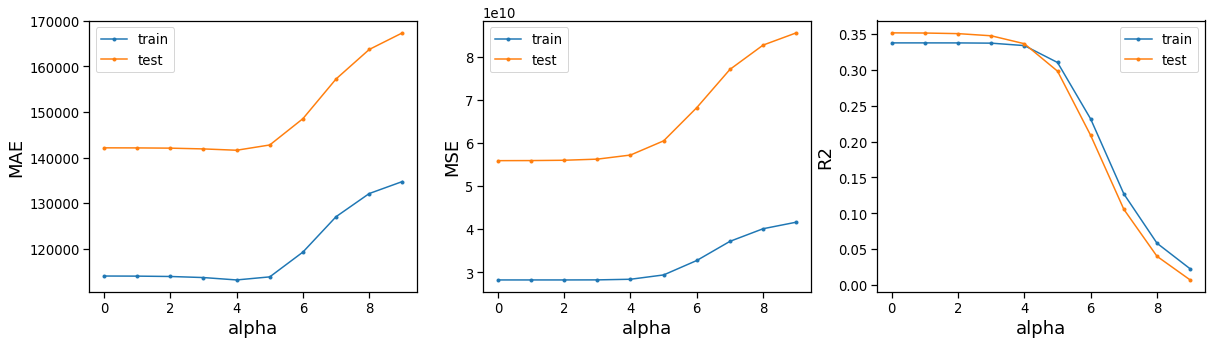

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5), sharex=True)
ax1.plot(train_MAEs,'.-')
ax1.plot(test_MAEs,'.-')
ax1.set_xlabel('alpha')
ax1.set_ylabel('MAE');
ax1.legend(['train', 'test'])

ax2.plot(train_MSEs,'.-')
ax2.plot(test_MSEs,'.-')
ax2.set_xlabel('alpha')
ax2.set_ylabel('MSE');
ax2.legend(['train', 'test'])

ax3.plot(train_r2s,'.-')
ax3.plot(test_r2s,'.-')
ax3.set_xlabel('alpha')
ax3.set_ylabel('R2');
ax3.legend(['train', 'test'])

# above tests demonstrate WE learned in previous class that all coefficients go to 0's when alpha is big enough (here it's 1.0E05); # when alpha is less than 500, it's effects on loss functions or variance is not significant

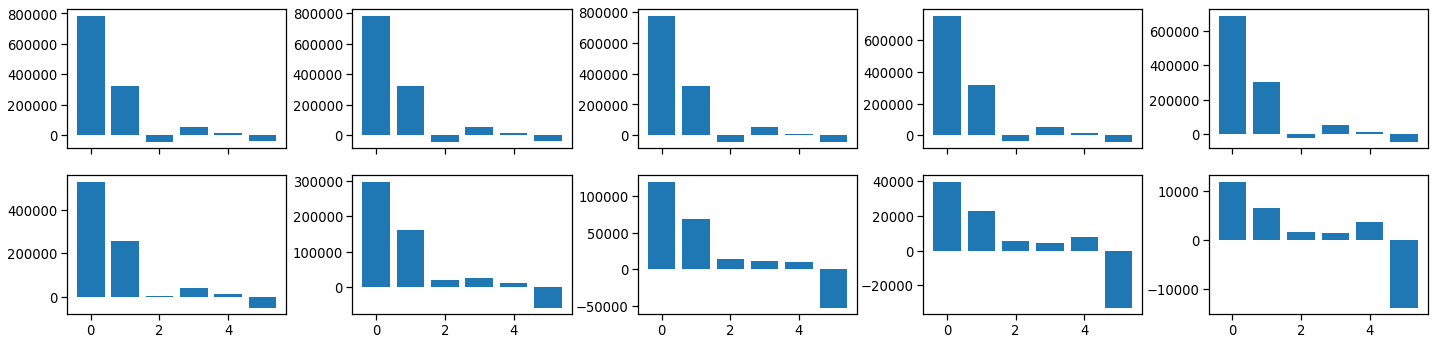

In [86]:
fig, axes = plt.subplots(2,5, figsize=(20,5),sharex=True)
axes = axes.ravel()
plt.tight_layout()
for i, ax in enumerate(axes):
    ax.bar(range(6), coefs[i])

#ax.set_yscale('log')

In [87]:
coefs

[array([786202.59217026, 324396.45607694, -45254.95684529,  54034.21189036,
         11237.25456739, -41149.12006912]),
 array([784331.33283036, 324051.60869859, -44838.90013848,  53968.28079164,
         11249.40184798, -41240.22323439]),
 array([777864.76248092, 322841.01985005, -43406.5024673 ,  53737.0534069 ,
         11290.19578405, -41554.5631532 ]),
 array([756145.4992312 , 318562.82919661, -38660.67770414,  52922.3621152 ,
         11413.91480619, -42604.53462473]),
 array([689555.89076459, 303470.87904233, -24852.06841044,  50070.87981784,
         11670.06246343, -45759.16196497]),
 array([530314.24778169, 256093.10721353,   2047.25663436,  41297.12581789,
         11613.95208544, -52713.18160732]),
 array([298062.20394131, 160893.82515421,  20293.20482828,  24849.49033796,
         10470.68533936, -59350.67641204]),
 array([120075.9503783 ,  68670.69747063,  14029.14325589,  11085.82553433,
          9751.93293278, -53288.55743683]),
 array([ 39646.61957692,  22496.448898  

<font color='blue' size=4>Above tests demonstrate what WE learned in previous class that all coefficients go down but NOT to 0's when alpha is increasing; # when alpha is less than 10, its effects on loss functions or variance is not significant. However, when alpha is 10 or bigger, the price vs cost plot is flatten</font>

#  <font color='red'>K-fold cross-validation</font>

## cross_val_score (bigger is better)

In [88]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

alphas = range(1, 1000, 30)
accuracy = []
for alpha in alphas :

    steps = [('Rescale', MinMaxScaler()),
             ('lasso', Lasso(alpha=1,max_iter = 1000000)), ] 
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    accuracy.append(accuracies.mean() )

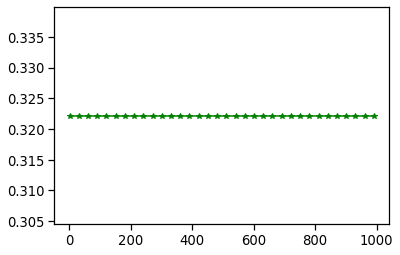

In [89]:
plt.plot(alphas, accuracy, 'g*-')

# judged by cross_val_score, alpha tested in the range from 1 to 1000, no significant difference

## MSE (smaller is better)

In [90]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=2019)

mean_mse = []
alphas = range(1, 300, 10)
for alpha in alphas:
    mse = []
    for train_index, test_index in kf.split(XX):
        X_train, X_valid = XX.iloc[train_index, :], XX.iloc[test_index, :]
        y_train, y_valid = yy.iloc[train_index], yy.iloc[test_index]

        steps = [('Rescale', MinMaxScaler()),
                 ('lasso', Lasso(alpha=alpha,max_iter = 1000000)), ] 
        model = Pipeline(steps)
        model = model.fit(X_train, y_train)
        
        mse.append(mean_squared_error(y_valid, model.predict(X_valid)))
    mean_mse.append(sum(mse)/len(mse))
    

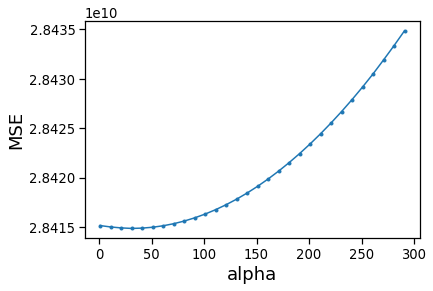

In [91]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(alphas, mean_mse, '.-')
ax1.set_xlabel('alpha');
ax1.set_ylabel('MSE');

#### alpha in between 10 and 50 is the best parameter

### <font color='red'>GridSearchCV</font> (can be used to find best values for multiple hyper parameters)

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
parameters = {'lasso__alpha': range(1,300, 10)}
scorer = make_scorer(mean_squared_error, greater_is_better = False)

steps = [('Rescale', MinMaxScaler()),
         ('lasso', Lasso(max_iter = 1000000)), ] 
pipe = Pipeline(steps)

model_gsv = GridSearchCV(pipe, parameters, cv = 5, scoring = scorer)
model_gsv

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Rescale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True,
                                              max_iter=1000000, normalize=False,
                                              positive=False, precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'lasso__alpha': range(1, 300, 10)},
        

In [93]:
model_gsv = model_gsv.fit(X, y)

In [94]:
model_gsv.best_params_

{'lasso__alpha': 101}

In [95]:
model_gsv.cv_results_

{'mean_fit_time': array([0.14209542, 0.07805643, 0.00958748, 0.01333199, 0.00478697,
        0.00478683, 0.00498629, 0.0033906 , 0.00319357, 0.0022017 ,
        0.00312481, 0.00020118, 0.0031251 , 0.00312433, 0.00624852,
        0.00624828, 0.        , 0.00312428, 0.00312424, 0.00312424,
        0.00625458, 0.        , 0.00627408, 0.00379062, 0.00319118,
        0.00259318, 0.00299144, 0.00339127, 0.00358982, 0.00180802]),
 'std_fit_time': array([0.06823701, 0.03975036, 0.00783783, 0.01306675, 0.00212869,
        0.00074625, 0.00141017, 0.00048877, 0.00040319, 0.00116172,
        0.00624962, 0.00040236, 0.00625019, 0.00624866, 0.00765285,
        0.00765255, 0.        , 0.00624857, 0.00624847, 0.00624847,
        0.00766027, 0.        , 0.00768439, 0.00039649, 0.00039902,
        0.00048854, 0.00063022, 0.00048852, 0.00048868, 0.00115444]),
 'mean_score_time': array([0.00019913, 0.00332365, 0.        , 0.        , 0.00039897,
        0.00079818, 0.00079784, 0.00059853, 0.00059829, 0.00

### alpha = 101 is the best parameter

## 4.4 Modeling: PCA and GridSearchCV

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
#from numpy.linalg import svd
#import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error,  make_scorer

parameters = [{'pca__n_components': range(1,5)}]
scorer = make_scorer(mean_squared_error, greater_is_better = False)  # if use alternative gridSCV then dont use this statement

steps = [('Rescale', MinMaxScaler()),
         ('pca', PCA()),
         ('lr', LinearRegression()), ]
model = Pipeline(steps)
#model = model.fit(X_train, y_train)   #test fit

gridSCV = GridSearchCV(model, parameters, cv = 5, scoring = scorer)
#gridSCV = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error',verbose=9)  #alternative
gridSCV

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Rescale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normaliz

In [97]:
gridSCV.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Rescale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normaliz

In [98]:
gridSCV.best_params_

{'pca__n_components': 4}

In [99]:
gridSCV.best_score_

-31719402881.785896

In [100]:
gridSCV.cv_results_['mean_test_score']

array([-3.94416617e+10, -3.94998754e+10, -3.94688241e+10, -3.17194029e+10])

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = Pipeline(steps = [
                          ('rescale', MinMaxScaler()),  
                           ('pca', PCA(n_components= 4 )),
                           ('lr', LinearRegression()), ])

# y_train = train_raw.price.map(lambda x: float(x.strip('$').replace(',', '')))
# y_test = test_raw.price.map(lambda x: float(x.strip('$').replace(',', '')))

model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

# print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
# print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
# print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

# print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
# print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
# print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

Train Loss | 	MAE: 1.20e+05	MSE:  3.10e+10	R^2:  0.2409
Test  Loss | 	MAE: 1.51e+05	MSE:  6.55e+10	R^2:  0.2403


In [102]:
MAEc['pcatr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['pcatr'] = mean_squared_error(y_train, y_train_pred);
R2c['pcatr'] = r2_score(y_train, y_train_pred)
MAEc['pcate']=mean_absolute_error(y_test, y_test_pred); 
MSEc['pcate'] = mean_squared_error(y_test, y_test_pred);
R2c['pcate'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051,
  'ridgetr': 113813.42623932038,
  'ridgete': 141991.96312083106,
  'pcatr': 120470.28430508767,
  'pcate': 150795.3609411041},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408,
  'ridgetr': 28243040089.24211,
  'ridgete': 56125458064.16162,
  'pcatr': 31049179309.617657,
  'pcate': 65490669467.11346},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.3513912644869379,
  'ridgetr': 0.33720200339332806,
  'ridgete': 0.34897640793609985,
  'pcatr': 0.2409219317454414,
  'pcate': 0.24034524877446684})

## 4.5 Modeling: Random Forest

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


steps = [
         ('rf', RandomForestRegressor(n_estimators = 10, random_state = 0) ),
        ]
model = Pipeline(steps)
model = model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
#y_train_pred

y_test_pred = model.predict(X_test)
#y_test_pred

In [104]:
print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

Train Loss | 	MAE: 4.64e+04	MSE:  5.91e+09	R^2:  0.8555
Test  Loss | 	MAE: 1.33e+05	MSE:  5.36e+10	R^2:  0.3777


In [105]:
MAEc['randFtr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['randFtr'] = mean_squared_error(y_train, y_train_pred);
R2c['randFtr'] = r2_score(y_train, y_train_pred)
MAEc['randFte']=mean_absolute_error(y_test, y_test_pred); 
MSEc['randFte'] = mean_squared_error(y_test, y_test_pred);
R2c['randFte'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051,
  'ridgetr': 113813.42623932038,
  'ridgete': 141991.96312083106,
  'pcatr': 120470.28430508767,
  'pcate': 150795.3609411041,
  'randFtr': 46430.06909294996,
  'randFte': 132685.84754079254},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408,
  'ridgetr': 28243040089.24211,
  'ridgete': 56125458064.16162,
  'pcatr': 31049179309.617657,
  'pcate': 65490669467.11346,
  'randFtr': 5911250518.331327,
  'randFte': 53648821294.72257},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.3513912644869379,
  'ridgetr': 0.33720200339332806,
  'ridgete': 0.34897640793609985,
  'pcatr': 0.2409219317454414,
  'pcate': 0.24034524877446684,
  'randFtr': 0.8554840828583898,
  'randFte': 0.37770399469422544})

<font color='red'>Plot the relationship between price and cost.</font> 

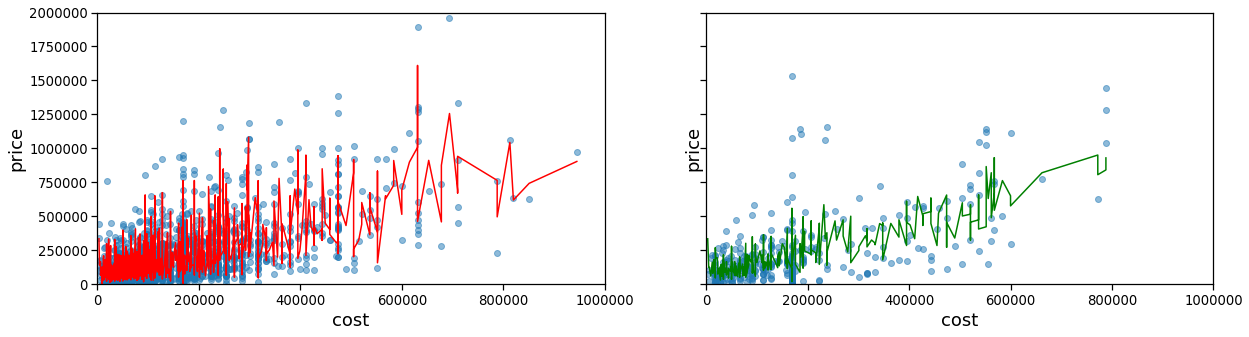

In [106]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

In [107]:
model.steps[0][1].feature_importances_

array([0.50393131, 0.26846436, 0.16511168, 0.00794144, 0.02427854,
       0.03027266])

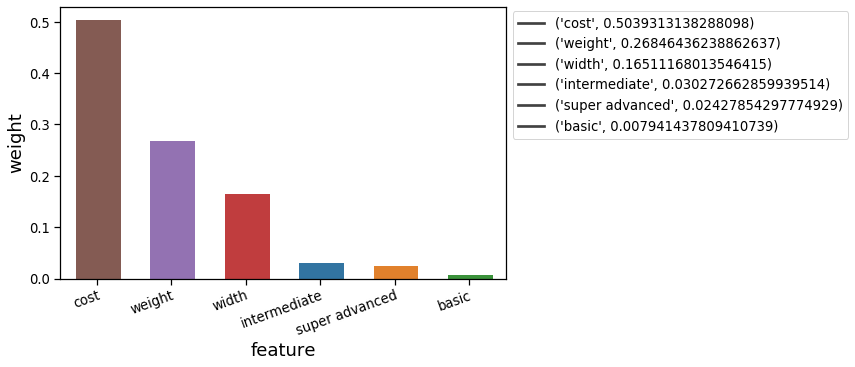

In [108]:
labels = ['0']*6
for i in range(6):
    labels[i] = features[i] + ' '+ str(model.named_steps['rf'].feature_importances_[i].round(4))  
sorted_imps = list(sorted(zip(features, model.named_steps['rf'].feature_importances_), key=lambda x:x[-1], reverse=True) )

import pylab as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# ax = sns.barplot(x=list(range(6)), y=model.named_steps['rf'].feature_importances_, #palette="Blues_d",
#                  hue=model.named_steps['rf'].feature_importances_, dodge = False,  )
ax = sns.barplot(x=list(range(6)), y=[e[1] for e in sorted_imps], #palette="Blues_d",
                 hue=model.named_steps['rf'].feature_importances_, dodge = False,  )
#ax = plt.step(x=list(range(6)), y=np.cumsum([e[1] for e in sorted_imps] ), where='mid')

#ax.set(xlabel= 'feature', ylabel='weight', xticklabels=features, );
ax.set(xlabel= 'feature', ylabel='weight', xticklabels=[e[0] for e in sorted_imps], )
#ax.legend(loc=1)
ax.legend(loc=6, bbox_to_anchor=(1.0, 0.75), labels=sorted_imps)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor") 
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .6)

change_width(ax, .6)

## 4.6 Modeling: Gradient Boosting Trees

In [109]:
from sklearn.ensemble import GradientBoostingRegressor

In [110]:
# the parameters were added after tuning hyperparameters with GridSearchCV
steps = [
         ('gbt', GradientBoostingRegressor(max_depth= 3,
                                           max_leaf_nodes=5,
                                           min_samples_leaf= 10,
                                           min_samples_split= 2)),
        ]
model = Pipeline(steps)
model = model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
#y_train_pred

y_test_pred = model.predict(X_test)
#y_test_pred

In [111]:
print(f"Train Loss | \tMAE: {mean_absolute_error(y_train, y_train_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_train, y_train_pred):.2e}"
        f"\tR^2:  {r2_score(y_train, y_train_pred):.4f}"
        f"\nTest  Loss | \tMAE: {mean_absolute_error(y_test, y_test_pred):.2e}"
        f"\tMSE:  {mean_squared_error(y_test, y_test_pred):.2e}"
        f"\tR^2:  {r2_score(y_test, y_test_pred):.4f}")

Train Loss | 	MAE: 9.47e+04	MSE:  2.00e+10	R^2:  0.5115
Test  Loss | 	MAE: 1.26e+05	MSE:  5.37e+10	R^2:  0.3765


In [112]:
MAEc['GBTtr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['GBTtr'] = mean_squared_error(y_train, y_train_pred);
R2c['GBTtr'] = r2_score(y_train, y_train_pred)
MAEc['GBTte']=mean_absolute_error(y_test, y_test_pred); 
MSEc['GBTte'] = mean_squared_error(y_test, y_test_pred);
R2c['GBTte'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051,
  'ridgetr': 113813.42623932038,
  'ridgete': 141991.96312083106,
  'pcatr': 120470.28430508767,
  'pcate': 150795.3609411041,
  'randFtr': 46430.06909294996,
  'randFte': 132685.84754079254,
  'GBTtr': 94671.58209591612,
  'GBTte': 126313.59405244893},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408,
  'ridgetr': 28243040089.24211,
  'ridgete': 56125458064.16162,
  'pcatr': 31049179309.617657,
  'pcate': 65490669467.11346,
  'randFtr': 5911250518.331327,
  'randFte': 53648821294.72257,
  'GBTtr': 19982642708.556416,
  'GBTte': 53749427623.41066},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.3513912644869379,
  'ridgetr': 0.33720200339332806,
  'ridgete': 0.34897640793609985,
  'pcatr': 0.2409219317454414,
  'pcate': 0.24034

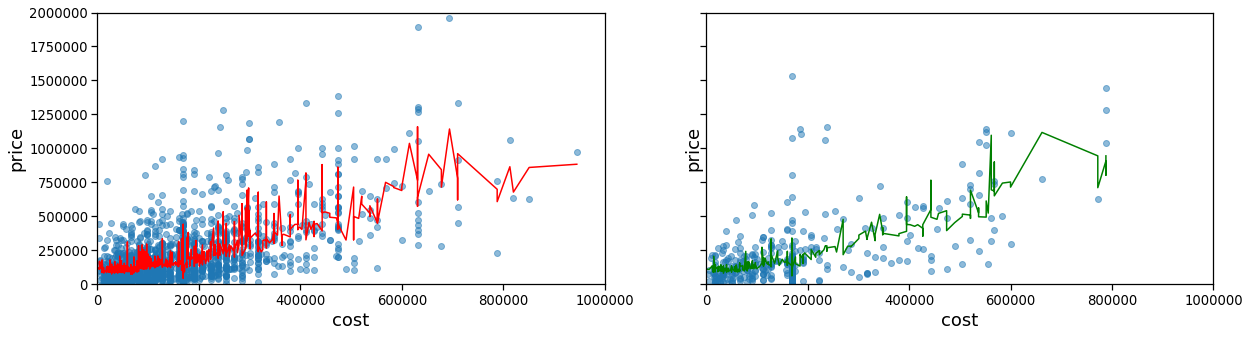

In [113]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

In [114]:
model.steps[0][1].feature_importances_

array([0.76733732, 0.13300234, 0.028421  , 0.00885815, 0.00684142,
       0.05553977])

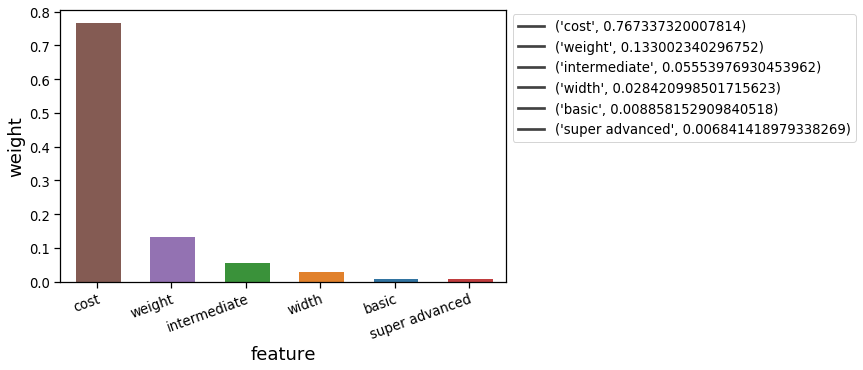

In [115]:
labels = ['0']*6
for i in range(6):
    labels[i] = features[i] + ' '+ str(model.named_steps['gbt'].feature_importances_[i].round(4))  
sorted_imps = list(sorted(zip(features, model.named_steps['gbt'].feature_importances_), key=lambda x:x[-1], reverse=True) )

import pylab as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# ax = sns.barplot(x=list(range(6)), y=model.named_steps['rf'].feature_importances_, #palette="Blues_d",
#                  hue=model.named_steps['rf'].feature_importances_, dodge = False,  )
ax = sns.barplot(x=list(range(6)), y=[e[1] for e in sorted_imps], #palette="Blues_d",
                 hue=model.named_steps['gbt'].feature_importances_, dodge = False,  )
#ax = plt.step(x=list(range(6)), y=np.cumsum([e[1] for e in sorted_imps] ), where='mid')

#ax.set(xlabel= 'feature', ylabel='weight', xticklabels=features, );
ax.set(xlabel= 'feature', ylabel='weight', xticklabels=[e[0] for e in sorted_imps], )
#ax.legend(loc=1)
ax.legend(loc=6, bbox_to_anchor=(1.0, 0.75), labels=sorted_imps)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor") 
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .6)

change_width(ax, .6)

## Tune hyperparameters with GridSearchCV and k-fold cross validation to optimize model performance.

In [116]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([
                    ('gbt', GradientBoostingRegressor(random_state=1999)),
                ])

parameters = {"gbt__max_depth": [None, 3, 5, 10],
              "gbt__min_samples_split": [2, 5, 10, 20],
              "gbt__min_samples_leaf": [1, 5, 10],
              "gbt__max_leaf_nodes": [None, 5, 10],
              }

gs = GridSearchCV(model, parameters, cv=5)
gs = gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [117]:
gs.best_params_

{'gbt__max_depth': 3,
 'gbt__max_leaf_nodes': 5,
 'gbt__min_samples_leaf': 10,
 'gbt__min_samples_split': 2}

In [118]:
gs.best_score_

0.35331027248863534

In [119]:
gs.cv_results_['mean_test_score']

array([-0.309752  , -0.0600478 , -0.00985897,  0.04367734,  0.03030194,
        0.03030194,  0.03030194,  0.09161182,  0.16991545,  0.16991545,
        0.16991545,  0.16991545,  0.31527884,  0.31300561,  0.31869601,
        0.32501807,  0.33088619,  0.33088619,  0.33088619,  0.32951888,
        0.34961148,  0.34961148,  0.34961148,  0.34961148,  0.26697176,
        0.27683474,  0.27684001,  0.28504149,  0.28544067,  0.28544067,
        0.28544067,  0.29510372,  0.32329504,  0.32329504,  0.32329504,
        0.32329504,  0.30119558,  0.30244631,  0.30996662,  0.31545477,
        0.32122833,  0.32122833,  0.32122833,  0.32316146,  0.34572069,
        0.34572069,  0.34572069,  0.34572069,  0.32741045,  0.33085442,
        0.32973251,  0.33210521,  0.33099463,  0.33099463,  0.33099463,
        0.33658872,  0.35331027,  0.35331027,  0.35331027,  0.35331027,
        0.3001303 ,  0.30144541,  0.31001207,  0.31545477,  0.32122833,
        0.32122833,  0.32122833,  0.32316146,  0.34572069,  0.34

## 4.7 Modeling: Xgboost

In [120]:
from xgboost import XGBRegressor

steps = [
         ('xgb', XGBRegressor(max_depth= 1,
                              max_leaf_nodes=None,
                              min_samples_leaf= 1,
                              min_samples_split= 2)),
        ]

In [121]:
model = Pipeline(steps)
model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
#y_train_pred
y_test_pred = model.predict(X_test)
#y_test_pred

[19:31:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)),
'\ttrain MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)),
'\ttrain R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)),

'\ntest  MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)),
'\ttest  MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)),
'\ttest  R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.01e+05 	train MSE: 2.34e+10 	train R2: 0.429 
test  MAE: 1.28e+05 	test  MSE: 5.34e+10 	test  R2: 0.381


In [123]:
MAEc['XGBtr']=mean_absolute_error(y_train, y_train_pred); 
MSEc['XGBtr'] = mean_squared_error(y_train, y_train_pred);
R2c['XGBtr'] = r2_score(y_train, y_train_pred)
MAEc['XGBte']=mean_absolute_error(y_test, y_test_pred); 
MSEc['XGBte'] = mean_squared_error(y_test, y_test_pred);
R2c['XGBte'] = r2_score(y_test, y_test_pred)
MAEc, MSEc, R2c

({'olstr': 114026.18514882588,
  'olste': 142142.36264466285,
  'lassotr': 114024.89361453612,
  'lassote': 142142.2114568051,
  'ridgetr': 113813.42623932038,
  'ridgete': 141991.96312083106,
  'pcatr': 120470.28430508767,
  'pcate': 150795.3609411041,
  'randFtr': 46430.06909294996,
  'randFte': 132685.84754079254,
  'GBTtr': 94671.58209591612,
  'GBTte': 126313.59405244893,
  'XGBtr': 101350.27532156618,
  'XGBte': 127717.2003751457},
 {'olstr': 28237461541.996464,
  'olste': 55916714076.703,
  'lassotr': 28237461843.3747,
  'lassote': 55917270631.74408,
  'ridgetr': 28243040089.24211,
  'ridgete': 56125458064.16162,
  'pcatr': 31049179309.617657,
  'pcate': 65490669467.11346,
  'randFtr': 5911250518.331327,
  'randFte': 53648821294.72257,
  'GBTtr': 19982642708.556416,
  'GBTte': 53749427623.41066,
  'XGBtr': 23361591799.168217,
  'XGBte': 53406298116.159515},
 {'olstr': 0.3373329188304307,
  'olste': 0.3513977202108557,
  'lassotr': 0.33733291175778946,
  'lassote': 0.351391264486

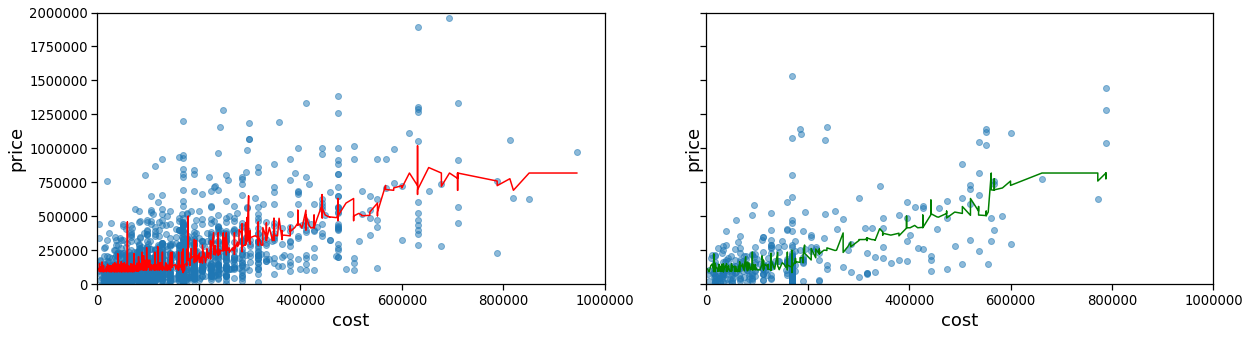

In [124]:
def plot_cost_price(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    #x = pd.DataFrame(np.linspace(0, 1e6), columns= ['cost'])
    #x = pd.DataFrame(np.arange(0, 1e6, 1), columns= ['cost']) 
    X_train_new = pd.DataFrame({'cost':X_train.cost, 'y_pred': y_train_pred, 'y':y_train})
    X_train_new = X_train_new.sort_values(by='cost')

    X_test_new = pd.DataFrame({'cost':X_test.cost, 'y_pred': y_test_pred, 'y':y_test})
    X_test_new = X_test_new.sort_values(by='cost')
    
    x_train = X_train #model[0].fit_transform(X_train)
    x_test =  X_test #model[0].transform(X_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
    ax1.scatter(x_train['cost'].values, y_train.values, alpha=0.5)
    ax1.set_xlim([0,1e6])
    ax1.set_ylim([0,2e6])
    ax1.set_xlabel('cost')
    ax1.set_ylabel('price')
    
    ax2.scatter(x_test['cost'].values, y_test.values, alpha=0.5)
    ax2.set_xlabel('cost')
    ax2.set_ylabel('price')
    
    
    #y = model.predict(x)
    ax1.plot(X_train_new['cost'].values, X_train_new['y_pred'].values, 'r-')
    ax2.plot(X_test_new['cost'].values, X_test_new['y_pred'].values, 'g-')
#     ax1.plot(x, y, 'r-')
#     ax2.plot(x, y, 'r-')    
plot_cost_price(model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred) 

In [125]:
model.steps[0][1].feature_importances_

array([0.670689  , 0.1570247 , 0.        , 0.02836272, 0.02575631,
       0.11816727], dtype=float32)

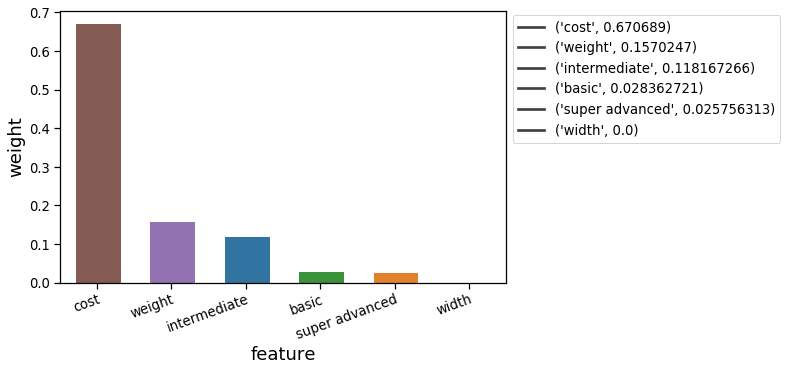

In [126]:
labels = ['0']*6
for i in range(6):
    labels[i] = features[i] + ' '+ str(model.named_steps['xgb'].feature_importances_[i].round(4))  
sorted_imps = list(sorted(zip(features, model.named_steps['xgb'].feature_importances_), key=lambda x:x[-1], reverse=True) )

import pylab as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# ax = sns.barplot(x=list(range(6)), y=model.named_steps['rf'].feature_importances_, #palette="Blues_d",
#                  hue=model.named_steps['rf'].feature_importances_, dodge = False,  )
ax = sns.barplot(x=list(range(6)), y=[e[1] for e in sorted_imps], #palette="Blues_d",
                 hue=model.named_steps['xgb'].feature_importances_, dodge = False,  )
#ax = plt.step(x=list(range(6)), y=np.cumsum([e[1] for e in sorted_imps] ), where='mid')

#ax.set(xlabel= 'feature', ylabel='weight', xticklabels=features, );
ax.set(xlabel= 'feature', ylabel='weight', xticklabels=[e[0] for e in sorted_imps], )
#ax.legend(loc=1)
ax.legend(loc=6, bbox_to_anchor=(1.0, 0.75), labels=sorted_imps)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor") 
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .6)

change_width(ax, .6)

In [127]:
## Tune hyperparameters with GridSearchCV and k-fold cross validation to optimize model performance.

from sklearn.model_selection import GridSearchCV

model = Pipeline([
                    ('xgb',XGBRegressor(random_state=43)),
                ])

parameters = {"xgb__max_depth": [1, 3, 5, 10],
              "xgb__min_samples_split": [2, 5, 10, 20],
              "xgb__min_samples_leaf": [1, 5, 10],
              "xgb__max_leaf_nodes": [None, 5, 10],
              }

gs = GridSearchCV(model, parameters, cv=5)
gs = gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [128]:
gs.best_params_

{'xgb__max_depth': 1,
 'xgb__max_leaf_nodes': None,
 'xgb__min_samples_leaf': 1,
 'xgb__min_samples_split': 2}

In [129]:
gs.best_score_

0.3527799783886376

In [130]:
gs.cv_results_['mean_test_score']

array([0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.35277998, 0.35277998, 0.35277998, 0.35277998,
       0.35277998, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.30950942, 0.30950942, 0.30950942,
       0.30950942, 0.30950942, 0.2323916 , 0.2323916 , 0.23239

### put all metrics together from all the modelings

In [131]:
R2n = sorted(R2c.items(), key=lambda x:x[0])
R2n

[('GBTte', 0.376537018143014),
 ('GBTtr', 0.5114722461880481),
 ('XGBte', 0.38051712649417224),
 ('XGBtr', 0.42886503384096963),
 ('lassote', 0.3513912644869379),
 ('lassotr', 0.33733291175778946),
 ('olste', 0.3513977202108557),
 ('olstr', 0.3373329188304307),
 ('pcate', 0.24034524877446684),
 ('pcatr', 0.2409219317454414),
 ('randFte', 0.37770399469422544),
 ('randFtr', 0.8554840828583898),
 ('ridgete', 0.34897640793609985),
 ('ridgetr', 0.33720200339332806)]

In [132]:
MAEn = sorted(MAEc.items(), key=lambda x:x[0])
MAEn

[('GBTte', 126313.59405244893),
 ('GBTtr', 94671.58209591612),
 ('XGBte', 127717.2003751457),
 ('XGBtr', 101350.27532156618),
 ('lassote', 142142.2114568051),
 ('lassotr', 114024.89361453612),
 ('olste', 142142.36264466285),
 ('olstr', 114026.18514882588),
 ('pcate', 150795.3609411041),
 ('pcatr', 120470.28430508767),
 ('randFte', 132685.84754079254),
 ('randFtr', 46430.06909294996),
 ('ridgete', 141991.96312083106),
 ('ridgetr', 113813.42623932038)]

In [133]:
MSEn = sorted(MSEc.items(), key=lambda x:x[0])
MSEn

[('GBTte', 53749427623.41066),
 ('GBTtr', 19982642708.556416),
 ('XGBte', 53406298116.159515),
 ('XGBtr', 23361591799.168217),
 ('lassote', 55917270631.74408),
 ('lassotr', 28237461843.3747),
 ('olste', 55916714076.703),
 ('olstr', 28237461541.996464),
 ('pcate', 65490669467.11346),
 ('pcatr', 31049179309.617657),
 ('randFte', 53648821294.72257),
 ('randFtr', 5911250518.331327),
 ('ridgete', 56125458064.16162),
 ('ridgetr', 28243040089.24211)]

## 4.8 Modeling: Metrics comparison from acrossing Modelings

In [134]:
Summary = pd.DataFrame({'Model':[MAEn[i][0] for i in range(14)], 
                        'MAE':[MAEn[i][1] for i in range(14)],
                        'MSE':[MSEn[i][1] for i in range(14)], 
                        'R2':[R2n[i][1] for i in range(14)]} )

In [135]:
Summary

,Model,MAE,MSE,R2
0,GBTte,126313.594052,5.374943e+10,0.376537
1,GBTtr,94671.582096,1.998264e+10,0.511472
2,XGBte,127717.200375,5.340630e+10,0.380517
3,XGBtr,101350.275322,2.336159e+10,0.428865
4,lassote,142142.211457,5.591727e+10,0.351391
5,lassotr,114024.893615,2.823746e+10,0.337333
6,olste,142142.362645,5.591671e+10,0.351398
7,olstr,114026.185149,2.823746e+10,0.337333
8,pcate,150795.360941,6.549067e+10,0.240345
9,pcatr,120470.284305,3.104918e+10,0.240922


# <font color='green'>Conclusion</font>: 
1. I prepared data by Backward Elimination regression of numerical features combining with transformed categorical features;
2. Final analysis data were chosen by Backward Elimination with p-Value < 0.05 and combined with adjusted R-squared. 6 variables related to 'price' are 'cost', 'weight', 'width',  'basic', 'super advanced', 'intermediate'. The last 3 variables were transformed from 'product_level';
2. For the modeling, evaluated by metrics MAE and MSE and R2, Gradient Booster, XGBoost, Lasso, Ordinary Linear Regression are doing better on this data;
3. Principal Component Analysis, Random Forest, Ridge Regression not as good as above methods on this data.